# Imports

In [1]:
import re
from os import makedirs, system
from pathlib import Path
from timeit import timeit
import matplotlib as mpl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from src import networks as nws
from src import pykwrapper as pkw
from pykinetic.writers.python import Batch as Writer
from pykinetic.classes import ConvergenceParameters, SimulationParameters, Compound
import seaborn as sns
from scipy.optimize import Bounds, minimize, root_scalar, root
from scipy.stats import pearsonr, linregress

import math

pd.options.display.max_columns = 100



params = {"font.family": "Arial", 'mathtext.default': 'regular'}      
plt.rc('font', size=8)
plt.rcParams.update(params)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
nice_structure_names = {
    "00-lpdoh2": "[LPd(OH)$_2$]",
    "100-l2pd2oh4": "[LPd(OH)$_2$]$_2$",
    "01-rxt": "RXT",
    "02-ts-rxt-c1": "RXT-C1",
    "03-c1": "C1",
    "04-ts-c1-c2": "C1-C2",
    "05-c2": "C2",
    "06-c2-h2o": "C2 + H$_2$O", 
    "07-ts-c2-c3": "C2-C3",
    "08-c3-boh3": "C3 + B(OH)$_3$", 
    "09-c3": "C3",
    "10-ts-c3-c4": "C3-C4",
    "11-c4": "C4",
    "12-ts-rxt-t1": "RXT-T1",
    "13-t1": "T1",
    "14-ts-t1-t2": "T1-T2",
    "15-t2": "T2",
    "16-t2-h2o": "T2 + H$_2$O", 
    "18-t3-boh3": "T3 + B(OH)$_3$", 
    "17-ts-t2-t3": "T2-T3",
    "19-t3": "T3",
    "20-ts-t3-t4": "T3-T4",
    "21-t4": "T4",
    "22-c5": "C5",
    "23-ts-c5-c6": "C5-C6",
    "24-t5": "T5",
    "25-ts-t5-t6": "T5-T6",
    "27-ts-t2-xa": "T2-XA",
    "28-xa": "XA",
    "29-ts-xa-t3": "XA-T3",
    "30-ts-t2-xb": "T2-XB",
    "31-xb": "XB",
    "32-ts-xb-t3": "XB-T3",
    "33-ts-rxt-ya": "RXT-YA",
    "34-ya": "YA",
    "35-ts-ya-c1": "YA-C1",
    "36-ts-rxt-yb": "RXT-YB",
    "37-yb": "YB",
    "38-ts-yb-c1": "YB-C1",
    "39-t2-lig": "T2 + L",
    "40-ts-t2-p1": "T2-P1",
    "42-p1-boh3": "P1 + B(OH)$_3$",
    "42-p1": "P1",
    "43-t3-lig": "T3 + L",
    "44-ts-t3-p1": "T3-P1",
    "45-p1-h2o": "P1 + H$_2$O",
    "76-t5ob-1h2o": "T5OB + H$_2$O",
    "binaph": "BiNaph",
    "pre-catalyst-dimer": "[Pd(OH)$_2$]$_2$",
    "pre-catalyst-monomer": "[Pd(OH)$_2$]",
    "ligand": "L",
    "naph-t": "Naph-T",
    'naphboh2': 'NaphB(OH)$_2$',
    'h2o': "H$_2$O",
    'boh3': "B(OH)$_3$",
    "e00-lpdoh2": "[LPd(OH)$_2$]$_2$",
    "e01-ecrxt": "ECRXT",
    "e02-ts-ecrxt-ec1": "ECRXT-EC1",
    "e03-ec1": "EC1",
    "e04-ts-ec1-ec2": "EC1-EC2",
    "e05-ec2": "EC2",
    "e06-ec2-h2o": "EC2 + H$_2$O", 
    "e07-ts-ec2-ec3": "EC2-EC3",
    "e08-ec3-bpinoh": "EC3 + BpinOH", 
    "e09-ec3": "EC3", 
    "e10-ts-ec3-ec4": "EC3-EC4",
    "e11-ec4": "EC4",
    "e12-etrxt": "ETRXT",
    "e13-ts-etrxt-et1": "ETRXT-ET1",
    "e14-et1": "ET1",
    "e15-ts-et1-et2": "ET1-ET2",
    "e16-et2": "ET2",
    "e17-et2-h2o": "ET2 + H$_2$O", 
    "e18-ts-et2-et3": "ET2-ET3",
    "e19-et3-bpinoh": "ET3 + BpinOH", 
    "e20-et3": "ET3",
    "e21-ts-et3-et4": "ET3-ET4",
    "e22-et4": "ET4",
    "e23-ts-etrxt-ec1b": "ETRXT-EC1B",
    "e24-ec1b": "EC1B",
    "e25-ts-ec1b-ec2b": "EC1B-EC2B",
    "e26-ec2b": "EC2B",
    "e27-ec2b-h2o": "EC2B + H$_2$O",
    "e28-ts-ec2b-ec3b": "EC2B-EC3B",
    "e29-ec3b-bpinoh": "EC3B + BpinOH",
    "e30-ts-ecrxt-et1b": "ECRXT-ET1B",
    "e31-et1b": "ET1B",
    "e32-ts-et1b-et2b": "ET1B-ET2B",
    "e33-et2b": "ET2B",
    "e34-et2b-h2o": "ET2B + H$_2$O",
    "e35-ts-et2b-et3b": "ET2B-ET3B",
    "e36-et3b-bpinoh": "ET3B + BpinOH",
    "naphbpin": "NaphBpin",
    "6cnnaph-t": "6-CN-Naph-T",
    '6cnnaphboh2': '6-CN-NaphB(OH)$_2$',
    "6cnnaphbpin": "6-CN-NaphBpin",
    "6omenaph-t": "6-OMe-Naph-T",
    '6omenaphboh2': '6-OMe-NaphB(OH)$_2$',
    "6omenaphbpin": "6-OMe-NaphBpin",
}

proper_names_dict = {'3z-adjohnphos': "AdJohnPhos",
 '3aa-adbrettphos': "AdBrettPhos",
 '3s-brettphos': "BrettPhos",
 '3m-cyjohnphos': "CyJohnPhos",
 '3n-cymephos': "CyMePhos",
 '3o-davephos': "DavePhos",
 '3j-iprjohnphos': "(i-Pr)JohnPhos",
 '3y-me4tbuxphos': "Me$_4$tBuXPhos",
 '3i-pad3': "P(Ad)$_3$",
 '3d-pcpt3': "P(Cpt)$_3$",
 '3f-pcy2tbu': "P(Cy)$_2$(t-Bu)",
 '3e-pcy3': "P(Cy)$_3$",
 '3k-phjohnphos': "PhJohnPhos",
 '3l-phdavephos': "PhDavePhos",
 '3c-pipr3': "P(i-Pr)$_3$",
 '3b-potol3': "P(o-tol)$_3$",
 '3a-pph3': "P(Ph)$_3$",
 '3g-ptbu2cy': "P(t-Bu)$_2$(Cy)",
 '3h-ptbu3': "P(t-Bu)$_3$",
 '3q-ruphos': "RuPhos",
 '3p-sphos': "SPhos",
 '3t-tbujohnphos': "JohnPhos",
 '3x-tbubrettphos': "tBuBrettPhos",
 '3v-tbudavephos': "tBuDavePhos",
 '3u-tbumephos': "tBuMePhos",
 '3w-tbuxphos': "tBuXPhos",
 '3r-xphos': "XPhos",   
 '9c-etjohnphos': "EtJohnPhos",
 '9d-mejohnphos': "MeJohnPhos",
 '9a-cbujohnphos': 'CbuJohnPhos',
 '9b-cptjohnphos': 'CptJohnPhos',
 '9e-pcbu3': 'P(Cbu)$_3$',     
 '9f-pcpr3': 'P(Cpr)$_3$',
 '9h-pme3': 'P(Me)$_3$',
 '9g-pet3': 'P(Et)$_3$',
 '6cn3e-pcy3': 'P(Cy)$_3$, 6-CN',
 '6cn3h-ptbu3': 'P(t-Bu)$_3$, 6-CN',
 '6cn3m-cyjohnphos': 'CyJohnPhos, 6-CN',
 '6cn3t-tbujohnphos': 'JohnPhos, 6-CN',
 '6ome3e-pcy3': 'P(Cy)$_3$, 6-OMe',
    '6ome3h-ptbu3': 'P(t-Bu)$_3$, 6-OMe',
    '6ome3m-cyjohnphos': 'CyJohnPhos, 6-OMe',
    '6ome3t-tbujohnphos': 'JohnPhos, 6-OMe',
}

In [4]:
DEBUG: bool = False  # Debug utilities

MK_T: float = 333.15               # Temperature (K)

kb: float = 1.38064852E-023     # Boltzmann Constant (kg·m2·s-2·K-1)
Na: float = 6.02214076E+023     # Avogadro's Number (mol-1)
h: float = 6.62607004E-034      # Plank Constant (m2·kg·s-1)
R: float = 8.31445985           # Ideal Gas Constant (kg⋅m2⋅s−2⋅K−1⋅mol−1)


def calc_kd (
    mu: float                   # Viscosity Constant (kg·m-1·s-1)
    , T: float=MK_T             # Temperature (K)
    , kb: float=kb              # Boltzmann Constant (kg·m2·s-2·K-1)
    , Na: float=Na              # Avogadro's Number (mol-1)
) -> float:         
    out: float = (kb * 8 * T)  # kg·m2·s-2·K-1 · K             -> kg·m2·s-2 
    out /= (3 * mu)            # kg·m2·s-2     / kg·m-1·s-1    -> m3·s-1
    out *= Na                  # m3·s-1        · mol-1         -> m3·mol-1·s-1
    return out                 # Diffusion constant kd (m3·mol-1·s-1)

def k2ae (
    kd: float                  # Diffusion constant kd (m3·mol-1·s-1)
    , T: float=MK_T            # Temperature (K)
    , kb: float=kb             # Boltzmann Constant (kg·m2·s-2·K-1)
    , R: float=R               # Ideal Gas Constant (kg⋅m2⋅s−2⋅K−1⋅mol−1)
    , h: float=h               # Planck Constant (m2·kg·s-1)
) -> float:
    ae: float = kb*(T)/h       # kg·m2·s-2·K-1 · K / m2·kg·s-1 -> s-1
    ae = kd/ae                 # m3·mol-1·s-1 / s-1            -> m3·mol-1
    ae = np.log(ae)            # m3·mol-1 · (c⊖)1–m (mol·m-3)  -> 1
    ae *= -R*(T)               # 1 · kg⋅m2⋅s−2⋅K−1⋅mol−1 · K   -> kg⋅m2⋅s−2⋅K−1⋅mol−1 
    return (ae)                # Ae (kg⋅m2⋅s−2⋅mol−1)[J·mol-1] -> J/mol
    
def joule2hartree (
    J: float
) -> float: 
    return J / 2625.5 / 1000

calc_ae = lambda x: joule2hartree(k2ae(calc_kd(x)))

def get_mk_file(D_NAME, mk_params, concentrations_dict, barrier_change=None):
    D_PATH: Path = Path("microkinetics")                    # Data directory
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    DS_DIR: Path = D_PATH/D_NAME                   # Dataset location
    RS_DIR: Path = R_PATH/D_NAME                   # Results location

    GRAPH_FILE: Path = RS_DIR/"graph.svg"          # Graph file path
    MODEL_FILE: Path = RS_DIR/f"{D_NAME}-model.py"           # MK model file path
    RESULTS_FILE: Path = RS_DIR/f"{D_NAME}-results.csv"      # Results path
    if DEBUG:
        SUM_PLT_FILE: Path = RS_DIR/"sum.png"      # Sum plot path
        INDEX_FILE: Path = RS_DIR/"indexfile.dat"  # Indexfile Path
    DIFF_EXP: bool = False             # Use explicit diffusion barrier value
    # If DIFF_EXP is False -> DIFF_Bar will be treated as the viscosity constant and the ae
    # for diffusion will be computed using the Eyring equation.
    DIFF_BAR: float | None = 2.09e-7                    
    # Diff threshold, reactions with an activation energy below this value will be considered
    # diffusion determined reactions with an activation barrier of DIFF_BAR. If set to None,
    # DIFF_THD == DIFF_BAR
    DIFF_THD: float | None = 1.6e-4 #  0.1 kcal/mol    


    MK_TFIN = mk_params['MK_TFIN']  # Simulation Time (s)
    MK_TREP = mk_params['MK_TREP']  # Simulation Log (s)
    MK_DT = mk_params['MK_DT']    # Simulation dt (s)
    ODE_RTOL: float = 1E-7   # Relative accuracy for the LSODA solver
    ODE_ATOL: float = 1E-12  # Absolute accuracy for the LSODA solver


    inters_df = pd.read_csv(DS_DIR/f"{D_NAME}-intermediates.csv")
    t_states_df = pd.read_csv(DS_DIR/f"{D_NAME}-transformations.csv")

    if barrier_change != None:
        for key in barrier_change.keys():
            t_states_df.loc[t_states_df['Flag'] == key, 'Energy'] += barrier_change[key]/2625.5*4.184

    makedirs(RS_DIR, exist_ok=True)

    inters = {r["structure"]: nws.Intermediate(code=r["structure"], energy=r["qh-G(T)_SPC"]) for _, r in inters_df.iterrows()}
    filter_nan = lambda xs: tuple([inters[a] for a in xs if not pd.isna(a)])
    get_ts_dict = lambda x: {
        "components": (filter_nan(x[0:2]), filter_nan(x[2:4]))
        , "energy": x["Energy"]
        , "backwards": x["Backwards"]
    }
    t_states = [nws.TransitionState(**get_ts_dict(ts)) for i, ts in t_states_df.iterrows()]
    org_net = nws.OrganicNetwork.from_dict({"intermediates": inters, "ts": t_states})

    diffusion = None
    if DIFF_BAR is not None: 
        if not DIFF_EXP: DIFF_BAR = calc_ae(DIFF_BAR)
        if not DIFF_THD: DIFF_THD = DIFF_BAR
        diffusion = (DIFF_BAR, DIFF_THD) 
        if DEBUG:
            print(
                "Diffusion barrier set to: {:.6f} hartrees, with threshold {:.6f} hartrees"
                .format(DIFF_BAR, DIFF_THD)
            )

    cs = pkw.nws_to_cs(org_net, temp=MK_T, diffusion=diffusion, unit='hartree')

    if DEBUG:
        from pykinetic.utils import write_indexfile
        write_indexfile(cs, INDEX_FILE, isrelative=True)

    initial_concentrations = {cs.compounds.index(Compound(reagent, '')): concentration 
                              for reagent, concentration in concentrations_dict.items()}


    simulation = SimulationParameters(
        concentrations=initial_concentrations
        , tfin=MK_TFIN
        , trep=MK_TREP
        , dt=MK_DT
    )
    convergence = ConvergenceParameters(rtol=ODE_RTOL,atol=ODE_ATOL)

    writer = Writer()
    writer.set_parameters(simulation=simulation, convergence=convergence)
    writer.parameters["out_filename"] = RESULTS_FILE
    writer.write(cs, filepath=MODEL_FILE)
    timeit(
    lambda: system(f"python {MODEL_FILE} > /dev/null")
    , number=1
    )
    
    header = ("time",) + tuple((c.label for c in cs.compounds))
    df = pd.read_csv(
        RESULTS_FILE
        , delimiter="\t"
        , header=None
        , names = header
    )

    # Normalizing the concentrations
    # in concentration_dict, find the name of the species that is either bpin or boh2
    boronic_species = [key for key in concentrations_dict.keys() if 'bpin' in key or 'boh2' in key][0]
    for col in df.columns[1:]:
        df[col] = df[col]/(concentrations_dict[boronic_species])

    return cs, df

def get_mk_profile(D_NAME, cs, df, concentrations_dict, desired_traces, plot=True, results_suffix="-results"):
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    RS_DIR: Path = R_PATH/D_NAME                   # Results location
    RESULTS_PLT_FILE: Path = RS_DIR/f"{D_NAME}{results_suffix}.png"  # Results plot path

    if plot == True:
        selected_cpds = {}
        for structure in desired_traces.keys():
            for cpd in cs.compounds:
                if cpd.label == structure:
                    selected_cpds[cpd] = {'label': nice_structure_names[cpd.label], 'color': desired_traces[structure]}

        if 'pre-catalyst-dimer' in concentrations_dict.keys():
            selected_cpds.pop(Compound('00-lpdoh2', ''), None)
            selected_cpds.pop(Compound('100-l2pd2oh4', ''), None)

        plt.rcParams['figure.dpi'] = 180
        plt.rcParams['figure.figsize'] = (4,4)

        fig, ax = plt.subplots()

        for compound, cpd_dict in selected_cpds.items():
            ax.plot(df["time"], df[compound.label], label=cpd_dict['label'], color=cpd_dict['color'])

        plt.legend(fontsize=6)
        plt.xlabel('reaction time / s')
        plt.ylabel('relative population')

        ax.spines[['right', 'top']].set_visible(False)           
        plt.tick_params(bottom=False) 

        ligand_name = re.sub(r'^[^-]*-', '', D_NAME)

        if ligand_name in proper_names_dict.keys():
            plt.title(f'L = {proper_names_dict[ligand_name]}')
        plt.savefig(RESULTS_PLT_FILE)
        plt.close()
        
    naph_species = [col for col in df.columns if 'naph-t' in col][0]
    
    if 'e05-ec2' in df.columns:
        return df[naph_species].iloc[-1], df['e05-ec2'].iloc[-1]
    else:
        return df[naph_species].iloc[-1], df['05-c2'].iloc[-1]

def check_convergence(df, column):
    return abs((df[column].iloc[-1])-(df[column].iloc[-2]))

def get_microkinetic_durations(mk_params_df, ligand):
    return mk_params_df.loc[mk_params_df['microkinetic_name'] == ligand][['MK_TFIN', 'MK_TREP', 'MK_DT']].to_dict('records')[0]

def get_microkinetic_yields(D_NAME, desired_yields):
    D_PATH: Path = Path("microkinetics")                    # Data directory
    R_PATH: Path = Path("microkinetics")                 # Results directory
    D_NAME: str = D_NAME                           # Name of the dataset

    DS_DIR: Path = D_PATH/D_NAME                   # Dataset location
    RS_DIR: Path = R_PATH/D_NAME                   # Results location

    RESULTS_FILE: Path = RS_DIR/f"{D_NAME}-results.csv"      # Results path

    inters_df = pd.read_csv(DS_DIR/f"{D_NAME}-intermediates.csv")
    t_states_df = pd.read_csv(DS_DIR/f"{D_NAME}-transformations.csv")

    inters = {r["structure"]: nws.Intermediate(code=r["structure"], energy=r["qh-G(T)_SPC"]) for _, r in inters_df.iterrows()}
    filter_nan = lambda xs: tuple([inters[a] for a in xs if not pd.isna(a)])
    get_ts_dict = lambda x: {
        "components": (filter_nan(x[0:2]), filter_nan(x[2:4]))
        , "energy": x["Energy"]
        , "backwards": x["Backwards"]
    }
    t_states = [nws.TransitionState(**get_ts_dict(ts)) for i, ts in t_states_df.iterrows()]
    org_net = nws.OrganicNetwork.from_dict({"intermediates": inters, "ts": t_states})


    cs = pkw.nws_to_cs(org_net, temp=MK_T, diffusion=None, unit='hartree')

    header = ("time",) + tuple((c.label for c in cs.compounds))
    df = pd.read_csv(
        RESULTS_FILE
        , delimiter="\t"
        , header=None
        , names = header
    )
    
    naph_species = [col for col in df.columns if 'naphboh2' in col or 'naphbpin' in col][0]
    naph_b_conc = df[naph_species].iloc[0]
    # Normalizing the concentrations
    for col in df.columns[1:]:
        df[col] = df[col]/(naph_b_conc)

    yield_dict = {}

    for cpd in desired_yields:
        for compound in cs.compounds:
            if compound.label == cpd:
                yield_dict[cpd] = df[compound.label].iloc[-1]

    return yield_dict

## Auto-generation of microkinetic duration parameters

In [5]:
def determine_initial_tfin(row):
    if row['microkinetic_type'] == 'p1':
        return 1E+2, 2
    elif row['min_of_max_barrier'] <= 17.8:
        return 1E-1, -1
    else:
        return 1E+4, 4
    
def initialize_mk_params(mk_tfin):
    return {'MK_TFIN': mk_tfin, 'MK_TREP': mk_tfin/1E+3, 'MK_DT': mk_tfin/1E+4}

def determine_concentrations_dict(row, equivs=3.5):
    concentrations_dict = {}
    functionalization = row['microkinetic_name'].split('-')[1][:-2]
    if row['microkinetic_type'] == 'p1':
        concentrations_dict = {'naphboh2': 0.02, 'pre-catalyst-dimer': 0.001, 'ligand': 0.002}
        concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equivs
    elif "6" in row['microkinetic_name'] and row['microkinetic_type'] == 'main':
        concentrations_dict = {f'{functionalization}naphboh2': 0.02, '100-l2pd2oh4': 0.001}
        concentrations_dict['h2o'] = concentrations_dict[f'{functionalization}naphboh2']*equivs
    elif "6" in row['microkinetic_name'] and row['microkinetic_type'] == 'ester':
        concentrations_dict = {f'{functionalization}naphbpin': 0.02, 'e100-l2pd2oh4': 0.001}
        concentrations_dict['h2o'] = concentrations_dict[f'{functionalization}naphbpin']*equivs
    elif row['microkinetic_type'] == 'ester':
        concentrations_dict = {'naphbpin': 0.02, 'e100-l2pd2oh4': 0.001}
        concentrations_dict['h2o'] = concentrations_dict['naphbpin']*equivs
    else:
        concentrations_dict = {'naphboh2': 0.02, '100-l2pd2oh4': 0.001}
        concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equivs

    return concentrations_dict
    
def determine_convergent_species(row):
    functionalization = row['microkinetic_name'].split('-')[1][:-2]
    convergent_species = ['00-lpdoh2', f'{functionalization}naph-t', '05-c2', '15-t2', '19-t3']
    if row['microkinetic_type'] == 'p1':
        convergent_species.append('42-p1')
        convergent_species.append('pre-catalyst-dimer')
    elif row['microkinetic_type'] == 'hc':
        convergent_species.append('binaph')
    elif row['microkinetic_type'] == 'ester':
        convergent_species = ['e00-lpdoh2', f'{functionalization}naph-t', 'e05-ec2', 'e16-et2', 'e20-et3']   
    return convergent_species

def optimize_mk_params(row, threshold=1e-07, equiv_list=[3.5]):
    mk_tfin, counter = determine_initial_tfin(row)
    status = {'trial_mk_params': initialize_mk_params(mk_tfin), 'converged': False, 'convergence_failure': False}
    D_NAME = row['microkinetic_name']
    concentrations_dict = determine_concentrations_dict(row, equivs=3.5)
    convergent_species = determine_convergent_species(row)
    while not status['converged']:
        cs, df = get_mk_file(D_NAME=D_NAME, mk_params=status['trial_mk_params'], concentrations_dict=concentrations_dict)
        if all([check_convergence(df, species) < threshold for species in convergent_species]):
            # next increment should also be converged
            lookahead_factor = 1E+1 if counter >= 6 else 1E+2
            test_convergence_mk_params = initialize_mk_params(status['trial_mk_params']['MK_TFIN']*lookahead_factor)
            test_cs, test_df = get_mk_file(D_NAME=D_NAME, mk_params=test_convergence_mk_params, concentrations_dict=concentrations_dict)
            if all([check_convergence(test_df, species) < threshold for species in convergent_species]):
                status['converged'] = True
                for equiv in equiv_list:
                    concentrations_dict = determine_concentrations_dict(row, equivs=equiv)
                    equiv_trial_mk_params = status['trial_mk_params'].copy()
                    for key in equiv_trial_mk_params.keys(): # ensure yield is fully converged
                        equiv_trial_mk_params[key] = equiv_trial_mk_params[key]*lookahead_factor
                    cs, df = get_mk_file(D_NAME=D_NAME, mk_params=equiv_trial_mk_params, concentrations_dict=concentrations_dict)
                    status['trial_mk_params'][f'comp_yield_{equiv}'], status['trial_mk_params'][f'c2_yield_{equiv}'] = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, 
                                                                                                                                      desired_traces="", plot=False)
                status['trial_mk_params']['microkinetic_name'] = D_NAME      
            elif counter == 8: #1e+9 starts to become numerically unstable
                status['converged'] = True
                status['convergence_failure'] = True
                print(f"{D_NAME} did not converge!")
            else:
                counter += 1
                for key in status['trial_mk_params'].keys():
                    status['trial_mk_params'][key] = status['trial_mk_params'][key]*1E+1
        elif counter == 8: #1e+9 starts to become numerically unstable
            status['converged'] = True
            status['convergence_failure'] = True
            print(f"{D_NAME} did not converge!")
        else:
            counter += 1
            for key in status['trial_mk_params'].keys():
                status['trial_mk_params'][key] = status['trial_mk_params'][key]*1E+1        
    return status

def plot_mk_file(row, mk_params, equiv=3.5):
    cmap = mpl.colormaps['tab10']
    desired_traces = {'00-lpdoh2': cmap.colors[2],
                'pre-catalyst-dimer': cmap.colors[2],
                '05-c2': "#C04A1B",
                '15-t2': cmap.colors[4],
                '19-t3': cmap.colors[6], 
                '31-xb': 'purple',
                '42-p1': 'lightseagreen',
                '76-t5ob-1h2o': '#b65a85',
                'binaph': 'darkgreen',
                'e00-lpdoh2': cmap.colors[2],
                'e05-ec2': "#C04A1B",
                'e16-et2': cmap.colors[4],
                'e20-et3': cmap.colors[6], 
                'naphbpin': "black", 
                'naphboh2': "black", 
                'naph-t': "#204195",
                '6cnnaphbpin': "black", 
                '6cnnaphboh2': "black", 
                '6cnnaph-t': "#204195",
                '6omenaphbpin': "black", 
                '6omenaphboh2': "black", 
                '6omenaph-t': "#204195",
                }
    D_NAME = row['microkinetic_name']
    concentrations_dict = determine_concentrations_dict(row, equivs=equiv)
    cs, df = get_mk_file(D_NAME=D_NAME, mk_params=mk_params, concentrations_dict=concentrations_dict)
    comp_yield, c2_yield = get_mk_profile(D_NAME=D_NAME, cs=cs, df=df, concentrations_dict=concentrations_dict, desired_traces=desired_traces, plot=True)
    return comp_yield, c2_yield

In [6]:
auto_generate = False
plot_mk = False
repopulate_yields = False
multiple_equivs = False
if auto_generate:
    mk_params_df = pd.read_csv("base_microkinetic_parameters.csv")
    trial_list = []
    equiv_list = [1.0, 5.0, 3.5]
    threshold_list = [5e-07, 5e-06, 1e-06, 5e-06, 1e-05]
    for _, row in mk_params_df.iterrows():
        print(row['microkinetic_name'])
        converged = False
        threshold_counter = 0
        threshold = threshold_list[threshold_counter]
        while not converged:
            trial_status = optimize_mk_params(row, threshold, equiv_list)
            if trial_status['convergence_failure']:
                print(f"Threshold {threshold} failed for {row['microkinetic_name']}")
                threshold_counter += 1
                threshold = threshold_list[threshold_counter]
            else:
                converged = True
        trial_list.append(trial_status['trial_mk_params'])             

    mk_params_df = pd.merge(mk_params_df, pd.DataFrame(trial_list), on='microkinetic_name', how='left')
    mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
    if plot_mk:
        for _, row in mk_params_df.iterrows():
            mk_params = get_microkinetic_durations(mk_params_df, row['microkinetic_name'])
            comp_yield, c2_yield = plot_mk_file(row, mk_params=mk_params, equiv=3.5)
else:
    try:
        mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
        if plot_mk:
            for _, row in mk_params_df.iterrows():
                equivs = [1.0, 5.0, 3.5] if multiple_equivs else [3.5]
                mk_params = get_microkinetic_durations(mk_params_df, row['microkinetic_name'])
                for equiv in equivs:
                    comp_yield, c2_yield = plot_mk_file(row, mk_params=mk_params, equiv=equiv)
                    if repopulate_yields:
                        mk_params_df.loc[mk_params_df['microkinetic_name'] == row['microkinetic_name'], f'comp_yield_{equiv}'] = comp_yield
                        mk_params_df.loc[mk_params_df['microkinetic_name'] == row['microkinetic_name'], f'c2_yield_{equiv}'] = c2_yield
            mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
    except FileNotFoundError:
        print("Microkinetic parameters missing! Use autotuner")

## Supplementary Table S29

In [7]:
main_ligands = mk_params_df[mk_params_df['microkinetic_type'] == 'main']['ligand_name'].unique()
main_params_df = mk_params_df[(mk_params_df['ligand_name'].isin(main_ligands)) & (mk_params_df['microkinetic_type'] == 'main')].copy()

main_list = []

for name in main_ligands:
    main_list.append(main_params_df[main_params_df['ligand_name'] == name][['ligand_name', 'comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'c2_yield_1.0', 'c2_yield_3.5', 'c2_yield_5.0']].iloc[0].tolist())

main_yields_df = pd.DataFrame(main_list, columns=['ligand_name', 'comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'c2_yield_1.0', 'c2_yield_3.5', 'c2_yield_5.0'])
# Multiply all values by 100
for equiv in [1.0, 3.5, 5.0]:
    main_yields_df[f'Naph-T/C2 ({equiv} eq.)'] = main_yields_df.apply(lambda row: f"{row[f'comp_yield_{equiv}']*100:.1f} / {row[f'c2_yield_{equiv}']*100:.1f}", axis=1)
columns_to_remove = ['comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'c2_yield_1.0', 'c2_yield_3.5', 'c2_yield_5.0']
main_yields_df = main_yields_df.drop(columns=columns_to_remove)
main_yields_df = main_yields_df.reindex([0, *np.linspace(2,26,25), 1, *np.linspace(27,34,8)]).reset_index(drop=True)
main_yields_df.to_csv("supplementary_table_s29.csv", index=False)


In [8]:
functionalized_ligands = []
for functionalization in ['6cn', '', '6ome']:
    for ligand in ['3e-pcy3', '3h-ptbu3', '3m-cyjohnphos', '3t-tbujohnphos']:
        functionalized_ligands.append(f"{functionalization}{ligand}")
    
main_params_df = mk_params_df[(mk_params_df['ligand_name'].isin(functionalized_ligands)) & ((mk_params_df['microkinetic_type'] == 'main') | (mk_params_df['microkinetic_type'] == 'ester'))].copy()


In [10]:
functionalized_ligands = []
for functionalization in ['6cn', '', '6ome']:
    for ligand in ['3e-pcy3', '3h-ptbu3', '3m-cyjohnphos', '3t-tbujohnphos']:
        functionalized_ligands.append(f"{functionalization}{ligand}")
    
main_params_df = mk_params_df[(mk_params_df['ligand_name'].isin(functionalized_ligands)) & ((mk_params_df['microkinetic_type'] == 'main') | (mk_params_df['microkinetic_type'] == 'ester'))].copy()

functionalized_list = []

for name in functionalized_ligands:
    tmp_acid_list = main_params_df[(main_params_df['ligand_name'] == name) & (main_params_df['microkinetic_type'] == 'main')][['ligand_name', 'comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'c2_yield_1.0', 'c2_yield_3.5', 'c2_yield_5.0']].iloc[0].tolist()
    tmp_ester_list = main_params_df[(main_params_df['ligand_name'] == name) & (main_params_df['microkinetic_type'] == 'ester')][['comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'c2_yield_1.0', 'c2_yield_3.5', 'c2_yield_5.0']].iloc[0].tolist()
    # combine the two lists
    tmp_list = tmp_acid_list + tmp_ester_list
    functionalized_list.append(tmp_list)

main_yields_df = pd.DataFrame(functionalized_list, columns=['ligand_name', 'comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'c2_yield_1.0', 'c2_yield_3.5', 'c2_yield_5.0', 
                                                  'ecomp_yield_1.0', 'ecomp_yield_3.5', 'ecomp_yield_5.0', 'ec2_yield_1.0', 'ec2_yield_3.5', 'ec2_yield_5.0',])
# Multiply all values by 100
for mk_type in ['', 'e']:
    for equiv in [1.0, 3.5, 5.0]:
        main_yields_df[f'Naph-T/{mk_type.upper()}C2 ({equiv} eq.)'] = main_yields_df.apply(lambda row: f"{row[f'{mk_type}comp_yield_{equiv}']*100:.1f} / {row[f'{mk_type}c2_yield_{equiv}']*100:.1f}", axis=1)
columns_to_remove = [x for x in main_yields_df.columns if 'yield' in x ]
main_yields_df = main_yields_df.drop(columns=columns_to_remove)
main_yields_df.to_csv("supplementary_table_s37.csv", index=False)


In [11]:
main_yields_df

,ligand_name,Naph-T/C2 (1.0 eq.),Naph-T/C2 (3.5 eq.),Naph-T/C2 (5.0 eq.),Naph-T/EC2 (1.0 eq.),Naph-T/EC2 (3.5 eq.),Naph-T/EC2 (5.0 eq.)
0,6cn3e-pcy3,0.1 / 9.9,0.5 / 9.9,0.7 / 9.9,0.0 / 9.8,0.0 / 9.7,0.0 / 9.6
1,6cn3h-ptbu3,91.1 / 6.4,98.8 / 1.2,99.1 / 0.9,87.4 / 1.0,99.7 / 0.3,99.8 / 0.2
2,6cn3m-cyjohnphos,24.6 / 10.0,35.3 / 10.0,37.4 / 10.0,0.0 / 9.9,0.0 / 9.7,0.0 / 9.6
3,6cn3t-tbujohnphos,82.1 / 8.8,97.6 / 2.4,98.1 / 1.9,19.0 / 9.9,66.3 / 9.9,90.0 / 9.4
4,3e-pcy3,0.1 / 10.0,0.4 / 10.0,0.5 / 10.0,0.0 / 9.9,0.0 / 9.8,0.0 / 9.7
5,3h-ptbu3,54.0 / 10.0,95.1 / 4.9,96.3 / 3.7,91.6 / 5.1,99.0 / 1.0,99.2 / 0.8
6,3m-cyjohnphos,27.5 / 10.0,44.5 / 10.0,48.5 / 10.0,0.1 / 10.0,0.2 / 10.0,0.3 / 10.0
7,3t-tbujohnphos,48.3 / 10.0,93.6 / 6.4,94.9 / 5.1,15.4 / 9.9,53.5 / 9.9,76.2 / 9.9
8,6ome3e-pcy3,0.1 / 9.9,0.3 / 9.8,0.4 / 9.7,0.0 / 9.7,0.0 / 9.5,0.0 / 9.4
9,6ome3h-ptbu3,13.9 / 10.0,48.0 / 10.0,67.9 / 10.0,8.5 / 10.0,25.7 / 10.0,34.0 / 10.0


## Supplementary Table S33

In [12]:
p1_ligands = mk_params_df[mk_params_df['microkinetic_type'] == 'p1']['ligand_name'].unique()
p1_main_params_df = mk_params_df[mk_params_df['ligand_name'].isin(p1_ligands)].copy()

overall_dict = {}

for name in p1_ligands:
    overall_dict[name] = {}
    main_dict = get_microkinetic_yields(f"main-{name}", ['05-c2', 'naph-t'])
    for key, value in main_dict.items():
        overall_dict[name][f"main-{key}"] = value  
    p1_dict = get_microkinetic_yields(f"p1-{name}", ['05-c2', '42-p1', 'naph-t'])
    for key, value in p1_dict.items():
        overall_dict[name][f"p1-{key}"] = value

p1_yield_df = pd.DataFrame(overall_dict).T
# Multiply all values by 100
p1_yield_df = p1_yield_df*100
p1_yield_df.to_csv("supplementary_table_s33.csv")

## Stitch Images

In [13]:
from PIL import Image
import numpy as np

def resize_images_to_same_height(images, target_height):
    resized_images = []
    for img in images:
        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(target_height * aspect_ratio)
        resized_img = img.resize((new_width, target_height), Image.LANCZOS)
        resized_images.append(resized_img)
    return resized_images

def stitch_images_horizontally(images):
    # Find the target height (minimum height of all images)
    target_height = min(img.height for img in images)

    # Resize images to the target height
    resized_images = resize_images_to_same_height(images, target_height)
    
    # Calculate the total width of the final stitched image
    total_width = sum(img.width for img in resized_images)

    # Create a new image with the appropriate size
    stitched_image = Image.new('RGB', (total_width, target_height))

    # Paste each image into the stitched image
    current_x = 0
    for img in resized_images:
        stitched_image.paste(img, (current_x, 0))
        current_x += img.width

    return stitched_image

In [14]:
stitch = False
if stitch:
    for name in mk_params_df['microkinetic_name']:
        list_im = [f'microkinetics/{name}/{name}-plot.png', f'microkinetics/{name}/{name}-results.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/{name}/{name}-merged.png')
        
    for name in ['main-3e-pcy3', 'main-3m-cyjohnphos']:
        list_im = [f'microkinetics/{name}/{name}-plot-btpp.png', f'microkinetics/{name}/{name}-results-btpp.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/{name}/{name}-merged-btpp.png')

    for name in mk_params_df[mk_params_df['microkinetic_type'] == 'p1']['ligand_name'].unique():
        list_im = [f'microkinetics/p1-{name}/p1-{name}-plot.png', f'microkinetics/main-{name}/main-{name}-results.png', f'microkinetics/p1-{name}/p1-{name}-results.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/p1-{name}/p1-{name}-comparativemerged.png')

    for name in ['3s-brettphos', '3aa-adbrettphos']:
        list_im = [f'microkinetics/ya-{name}/ya-{name}-plot.png', f'microkinetics/ya-{name}/ya-{name}-results.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/ya-{name}/ya-{name}-merged.png')

    for name in mk_params_df[mk_params_df['microkinetic_type'] == 'ob']['ligand_name'].unique():
        list_im = [f'microkinetics/ob-{name}/ob-{name}-plot.png', f'microkinetics/ob-{name}/ob-{name}-results.png', f'microkinetics/ob-{name}/ob-{name}-results-nodirect.png']
        imgs    = [ Image.open(i) for i in list_im ]
        stitch_images_horizontally(imgs).save(f'microkinetics/ob-{name}/ob-{name}-comparativemerged.png')
        
    for name in ['3e-pcy3', '3h-ptbu3', '3m-cyjohnphos', '3t-tbujohnphos']:
        for functionalization in ["", "6cn", "6ome"]:
            for mk_type in ['main', 'ester']:
                list_im = [f'microkinetics/{mk_type}-{functionalization}{name}/{mk_type}-{functionalization}{name}-plot-rxtref.png', f'microkinetics/{mk_type}-{functionalization}{name}/{mk_type}-{functionalization}{name}-results.png']
                imgs    = [ Image.open(i) for i in list_im ]
                stitch_images_horizontally(imgs).save(f'microkinetics/{mk_type}-{functionalization}{name}/{mk_type}-{functionalization}{name}-merged-rxtref.png')

## Supplementary Discussion S7.7.2

In [15]:
def get_second_order_barrier_correction(concentration, temperature):
    return math.log(1/concentration)*temperature*8.314/1000/4.184

def get_barrier_for_target_yield(barrier_change, equiv, target, D_NAME='simplified'):
    concentrations_dict = {'naphboh2': 0.02, '100-l2pd2oh4': 0.001} # units are in M 
    concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equiv
    mk_params = {'MK_TFIN': 1E+6}
    mk_params['MK_TREP'] = mk_params['MK_TFIN']/1E+1
    mk_params['MK_DT'] = mk_params['MK_TFIN']/1E+2
    barrier_change = {'c-tdts': barrier_change}
    _, df = get_mk_file(D_NAME=D_NAME, mk_params=mk_params, concentrations_dict=concentrations_dict, barrier_change=barrier_change)
    comp_yield = df['naph-t'].iloc[-1]
    return comp_yield-target

def get_yield_for_target_barrier(barrier, equiv, D_NAME='simplified'):
    concentrations_dict = {'naphboh2': 0.02, '100-l2pd2oh4': 0.001} # units are in M 
    concentrations_dict['h2o'] = concentrations_dict['naphboh2']*equiv
    mk_params = {'MK_TFIN': 1E+6}
    mk_params['MK_TREP'] = mk_params['MK_TFIN']/1E+1
    mk_params['MK_DT'] = mk_params['MK_TFIN']/1E+2
    barrier_change = {'c-tdts': barrier}
    _, df = get_mk_file(D_NAME=D_NAME, mk_params=mk_params, concentrations_dict=concentrations_dict, barrier_change=barrier_change)
    comp_yield = df['naph-t'].iloc[-1]
    return comp_yield

In [16]:
obtain_ddg_curves = False

if obtain_ddg_curves:
    target_yields = np.concatenate((np.linspace(0.005, 0.05, 10), np.linspace(0.06, 0.19, 14), np.linspace(0.20, 0.90, 15), np.linspace(0.905, 0.995, 19)))
    target_equivalents = [1, 3.5, 5]
    trial_list = []
    for equivalents in target_equivalents:
        correction = get_second_order_barrier_correction(concentration=0.02*equivalents, temperature=333.15)
        for target in target_yields:
            print(equivalents, target)
            res = root(get_barrier_for_target_yield, x0=[0 if target < 0.5 else 3], args=(equivalents, target, "simplified"))
            ddG = res['x'][0]
            trial_ddG_params = {"equivalents": equivalents, "comp_yield": target, "ddG": ddG, "corrected_ddG": ddG-correction,}
            trial_list.append(trial_ddG_params)
            
    ddg_df = pd.DataFrame(trial_list)
    ddg_df['nice_comp_yield'] = ddg_df['comp_yield']*100
    ddg_df.to_csv("ddg_curves.csv", index=False)
else:
    try:
        ddg_df = pd.read_csv("ddg_curves.csv")
    except FileNotFoundError:
        print("Obtain ddg curves! Approx 30 minutes")

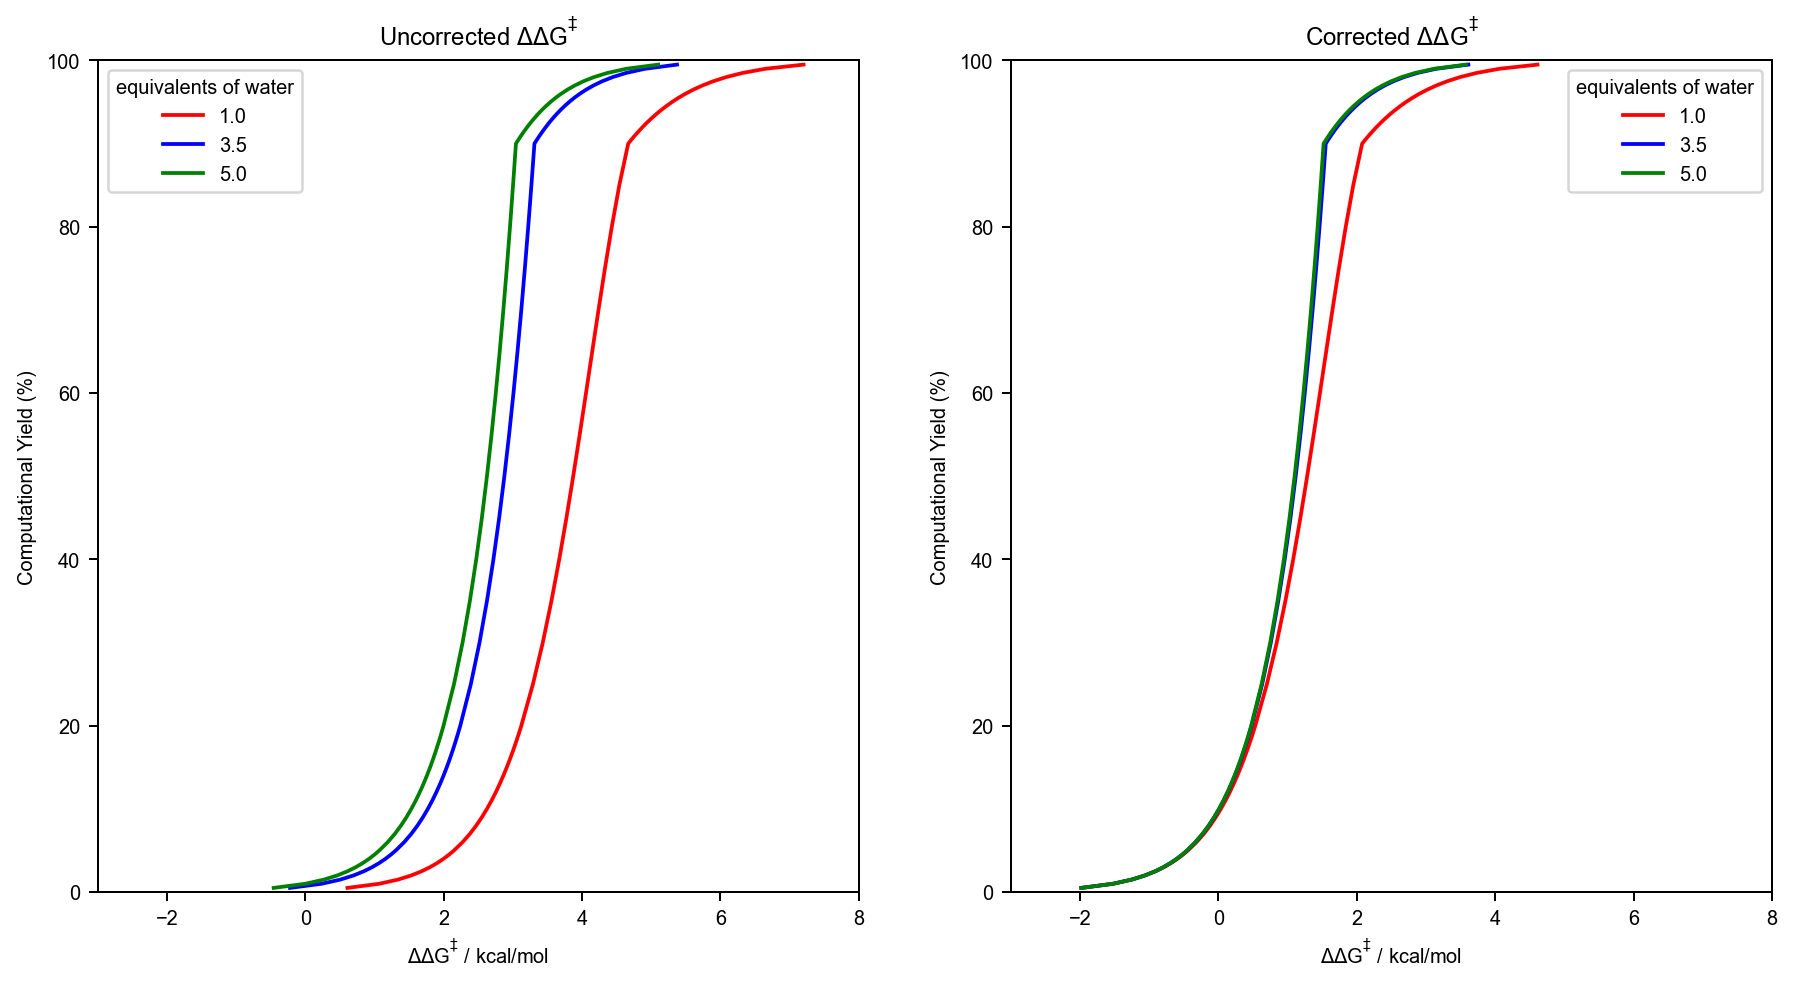

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=180)

ddg_df['nice_yield'] = ddg_df['comp_yield']*100

g1 = sns.lineplot(x="ddG", y="nice_yield", ax=ax[0], data=ddg_df[ddg_df['equivalents'] == 1.0], label="1.0", color='r')
g2 = sns.lineplot(x="ddG", y="nice_yield", ax=ax[0], data=ddg_df[ddg_df['equivalents'] == 3.5], label="3.5", color='b')
g3 = sns.lineplot(x="ddG", y="nice_yield", ax=ax[0], data=ddg_df[ddg_df['equivalents'] == 5.0], label="5.0", color='g')

g1 = sns.lineplot(x="corrected_ddG", y="nice_yield", ax=ax[1], data=ddg_df[ddg_df['equivalents'] == 1.0], label="1.0", color='r')
g2 = sns.lineplot(x="corrected_ddG", y="nice_yield", ax=ax[1], data=ddg_df[ddg_df['equivalents'] == 3.5], label="3.5", color='b')
g3 = sns.lineplot(x="corrected_ddG", y="nice_yield", ax=ax[1], data=ddg_df[ddg_df['equivalents'] == 5.0], label="5.0", color='g')

for axis in ax:
    axis.set_ylim([-0,100])
    axis.set_xlim([-3,8])
    axis.set_ylabel("Computational Yield (%)")
    axis.set_xlabel("$\Delta\Delta G^{\u2021}$ / kcal/mol")
    axis.legend(title="equivalents of water")

ax[0].set_title("Uncorrected $\Delta\Delta G^{\u2021}$")    
ax[1].set_title("Corrected $\Delta\Delta G^{\u2021}$")

plt.savefig('figures/figures53.png', transparent=True, bbox_inches="tight")

## Barrier Tuning To Parity (full)

In [18]:
def get_barrier_tuning_to_parity_yield(barrier_change, mk_params_df, ligand, equiv, target):
    functionalization = ligand.split('-')[1].split('3')[0]
    concentrations_dict = determine_concentrations_dict(mk_params_df[mk_params_df['microkinetic_name'] == ligand].iloc[0], equivs=equiv)
    barrier_change_dict = {}
    print(barrier_change)
    for ts in ['02-ts-rxt-c1', '04-ts-c1-c2', '33-ts-rxt-ya', '35-ts-ya-c1', '36-ts-rxt-yb', '38-ts-yb-c1', '40-ts-t2-p1', '42-ts-t3-p1',
               "e02-ts-ecrxt-ec1", "e04-ts-ec1-ec2"]:
        barrier_change_dict[ts] = barrier_change   
    for ts in ['12-ts-rxt-t1', '14-ts-t1-t2', '17-ts-t2-t3', '20-ts-t3-t4', '27-ts-t2-xa', '29-ts-xa-t3', '30-ts-t2-xb', '32-ts-xb-t3', 
               '60-ts-t2-t3ob', "64-ts-t3ob-t4ob", "66-ts-t2-t4ob", "68-ts-t4ob-t4-4mps", "71-ts-t4ob-t4-6mps", "73-ts-t4ob-t5ob",
               "77-ts-t5ob-t6ob-4mps", "80-ts-t5ob-t6ob-6mps", "82-ts-t2-t3-4mps", "83-ts-t2-t3-6mps",
               "e13-ts-etrxt-et1", "e15-ts-et1-et2", "e18-ts-et2-et3", "e21-ts-et3-et4"]:      
        barrier_change_dict[ts] = -barrier_change
        
    mk_params = get_microkinetic_durations(mk_params_df, ligand)
    for key in mk_params.keys():
        mk_params[key] = mk_params[key]*1E+1 # ensure convergence
        
    cs, df = get_mk_file(D_NAME=ligand, mk_params=mk_params, concentrations_dict=concentrations_dict, barrier_change=barrier_change_dict)
    comp_yield = df[f'{functionalization}naph-t'].iloc[-1]
    return comp_yield-target

In [19]:
barrier_tuning = False

if barrier_tuning:
    barrier_tuning_dict = {}
    main_ligands_df = mk_params_df.copy()
    #main_ligands_df = mk_params_df[mk_params_df['microkinetic_type'] == 'p1'].copy()
    for _, row in main_ligands_df.iterrows():
        ligand = row['microkinetic_name']
        print(ligand)
        target = row['exp_yield']
        equiv = 3.5
        if math.isnan(target):
            barrier_tuning_dict[ligand] = np.nan # only possible to tune for experimental yields
        else:
            res = root_scalar(get_barrier_tuning_to_parity_yield, args=(main_ligands_df, ligand, equiv, target), method='brentq', bracket=[-10,10], maxiter=40, xtol=1e-6)
            if not res.converged:
                print(f"Failed to tune {ligand}")
                barrier_tuning_dict[ligand] = np.nan
            else:
                barrier_tuning_dict[ligand] = res.root
    mk_params_df['barrier_tuning_to_parity'] = mk_params_df['microkinetic_name'].map(barrier_tuning_dict)
    mk_params_df.to_csv("autotuned_microkinetic_parameters.csv", index=False)
else:
    try:
        mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
        barrier_tuning = mk_params_df['barrier_tuning_to_parity']
    except KeyError:
        print("Barrier tuning to parity does not exist! Run barrier tuning")

In [20]:
print(get_barrier_tuning_to_parity_yield(-2.24, mk_params_df, 'main-3h-ptbu3', 3.5, 0))

-2.24
0.010472783531607863


## Merge all dataframes

In [32]:
dataframe_merge = True

if dataframe_merge:
    barrier_df = pd.read_csv("all_barriers.csv")
    barrier_df.rename(columns={"group": "ligand_name"}, inplace=True)
    barrier_df['exp_name'] = barrier_df.apply(lambda row: row['ligand_name'].split('-')[0], axis=1)
    barrier_df['ddG_corr_3.5_minus'] = barrier_df['ddG_corr_3.5'] - barrier_df['ddG_corr_1.0']
    barrier_df['ddG_corr_3.5_plus'] = barrier_df['ddG_corr_5.0'] - barrier_df['ddG_corr_3.5']
    mk_params_df = pd.read_csv("autotuned_microkinetic_parameters.csv")
    mk_pivoted_df = mk_params_df.pivot(index='ligand_name', columns='microkinetic_type', 
                    values=['comp_yield_1.0', 'comp_yield_3.5', 'comp_yield_5.0', 'barrier_tuning_to_parity'])
    mk_pivoted_df.columns = [f'{col[0]}_{col[1]}' for col in mk_pivoted_df.columns]
    mk_pivoted_df = mk_pivoted_df.reset_index()
    barrier_df = barrier_df.merge(mk_pivoted_df)
    barrier_df['prediction_quality'] = barrier_df.apply(lambda row: "Good" if abs(row['barrier_tuning_to_parity_main']) <= 1.0 else "Poor", axis=1)

    kraken_df = pd.read_csv("kraken_descriptors.csv")

    barrier_df = barrier_df.merge(kraken_df, left_on="ligand_name", right_on="name")
    barrier_df.drop(columns=["name"], inplace=True)
    barrier_df.to_csv("full_processed_data.csv", index=False)
    nice_yields_list = ['exp_yield', 'exp_error']
    for equiv in [1.0, 3.5, 5.0]:
        for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'yayb']:
            nice_yields_list.append(f'comp_yield_{equiv}_{mk_type}')
    for col in nice_yields_list:
        barrier_df[f"nice_{col}"] = barrier_df[col]*100

    for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'yayb']:
        barrier_df[f'nice_comp_yield_3.5_{mk_type}_minus'] = barrier_df[f'nice_comp_yield_3.5_{mk_type}'] - barrier_df[f'nice_comp_yield_1.0_{mk_type}']
        barrier_df[f'nice_comp_yield_3.5_{mk_type}_plus'] = barrier_df[f'nice_comp_yield_5.0_{mk_type}'] - barrier_df[f'nice_comp_yield_3.5_{mk_type}']
else:
    try:
        barrier_df = pd.read_csv("full_processed_data.csv")
        nice_yields_list = ['exp_yield', 'exp_error']
        for equiv in [1.0, 3.5, 5.0]:
            for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'yayb']:
                nice_yields_list.append(f'comp_yield_{equiv}_{mk_type}')
        for col in nice_yields_list:
            barrier_df[f"nice_{col}"] = barrier_df[col]*100

        for mk_type in ['hc', 'main', 'ob', 'p1', 'pd3oac6', 'yayb']:
            barrier_df[f'nice_comp_yield_3.5_{mk_type}_minus'] = barrier_df[f'nice_comp_yield_3.5_{mk_type}'] - barrier_df[f'nice_comp_yield_1.0_{mk_type}']
            barrier_df[f'nice_comp_yield_3.5_{mk_type}_plus'] = barrier_df[f'nice_comp_yield_5.0_{mk_type}'] - barrier_df[f'nice_comp_yield_3.5_{mk_type}']

    except FileNotFoundError:
        print("Merge dataframes!")

## Figure 6

In [33]:
main_barrier_df = barrier_df[~barrier_df['ligand_name'].str.contains('9')].copy()

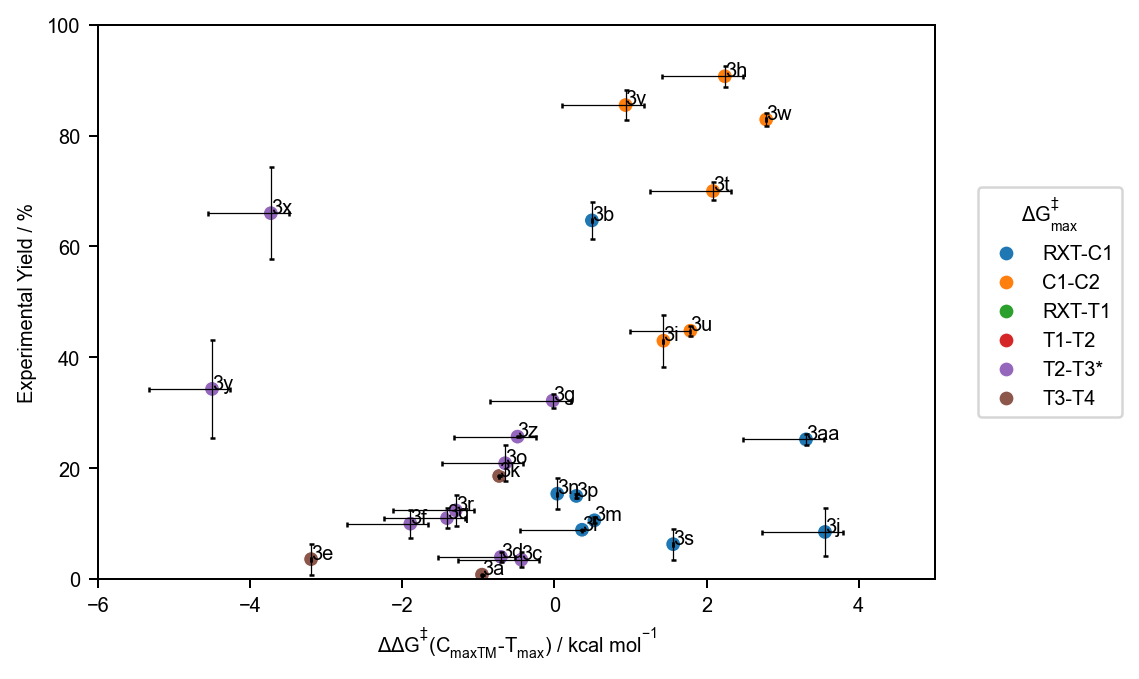

In [34]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=180)
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', '17-ts-t2-t3-corr_3.5', '20-ts-t3-t4']
equiv = 3.5

x = f'ddG_corr_{equiv}'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', palette='tab10', ax=ax)
g5 = plt.errorbar(x=x, y=y, xerr=(main_barrier_df[f'ddG_corr_{equiv}_minus'], main_barrier_df[f'ddG_corr_{equiv}_plus']), 
                  yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8,)

ax.set_xlabel('$\Delta\Delta$G$^{\u2021}$(C$_{maxTM}$-T$_{max}$) / kcal mol$^{-1}$')
ax.set_ylabel('Experimental Yield / %')
#ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlim([-6, 5])
ax.set_ylim([0, 100])
handles, labels = plt.gca().get_legend_handles_labels()


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left", title="$\Delta$G$^{\u2021}_{max}$").get_texts()
text_list[0].set_text('RXT-C1')
text_list[1].set_text('C1-C2')
text_list[2].set_text('RXT-T1')
text_list[3].set_text('T1-T2')
text_list[4].set_text('T2-T3*')
text_list[5].set_text('T3-T4')

plt.savefig('figures/figure6.png', transparent=True, bbox_inches="tight")


## Figure 8

In [35]:
import numpy as np
from scipy.interpolate import CubicSpline, interp1d
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt

def create_interpolation_function(points: List[Tuple[float, float]],) -> Callable[[float], float]:
    """
    Creates an interpolation function using various methods suitable for S-shaped curves.
    
    Args:
        points: List of tuples containing (x, y) coordinates, must be sorted by x
        method: Interpolation method ('linear', 'cubic_spline', 'cubic', 'pchip')
        
    Returns:
        A function that takes an x value and returns the interpolated y value
    """
    if not points:
        raise ValueError("Points list cannot be empty")
    
    # Convert points to numpy arrays
    points = np.array(sorted(points))
    x_points, y_points = points[:, 0], points[:, 1]
    interpolator = CubicSpline(x_points, y_points, bc_type='natural')
    def interpolate(x: float) -> float:
        """Returns the interpolated y value for a given x."""
        if np.isscalar(x):
            x = np.array([x])
        return interpolator(x)[0] if len(x) == 1 else interpolator(x)
    
    return interpolate

In [36]:
try_ddg_35 = ddg_df[ddg_df['equivalents'] == 3.5].copy()
interp_func_35 = create_interpolation_function(zip(try_ddg_35['nice_yield'], try_ddg_35['corrected_ddG']))    
inverse_interp_func_35 = create_interpolation_function(zip(try_ddg_35['corrected_ddG'], try_ddg_35['nice_yield']))
ideal_comp_ddgs_35 = [interp_func_35(x) for x in main_barrier_df['nice_comp_yield_3.5_main']]
ideal_comp_ddgs_1 = [interp_func_35(x) for x in main_barrier_df['nice_comp_yield_1.0_main']]
ideal_comp_ddgs_5 = [interp_func_35(x) for x in main_barrier_df['nice_comp_yield_5.0_main']]
ideal_exp_ddgs = [interp_func_35(x) for x in main_barrier_df['nice_exp_yield']]

main_barrier_df['ideal_comp_ddgs_3.5'] = ideal_comp_ddgs_35
main_barrier_df['ideal_comp_ddgs_1.0'] = ideal_comp_ddgs_1
main_barrier_df['ideal_comp_ddgs_5.0'] = ideal_comp_ddgs_5
main_barrier_df['ideal_comp_ddgs_3.5_minus'] = main_barrier_df['ideal_comp_ddgs_3.5'] - main_barrier_df['ideal_comp_ddgs_1.0']
main_barrier_df['ideal_comp_ddgs_3.5_plus'] = main_barrier_df['ideal_comp_ddgs_5.0'] - main_barrier_df['ideal_comp_ddgs_3.5']
main_barrier_df['ideal_exp_ddgs'] = ideal_exp_ddgs
main_barrier_df['distances'] = -(main_barrier_df['ideal_comp_ddgs_3.5'] - main_barrier_df['ideal_exp_ddgs'])/2
main_barrier_df['deviation'] = main_barrier_df['distances'] - main_barrier_df['barrier_tuning_to_parity_main']

In [37]:
interp_func_35(95.0)

np.float64(2.051484193763192)

In [38]:
inverse_interp_func_35(4.05)

np.float64(99.96418060430838)

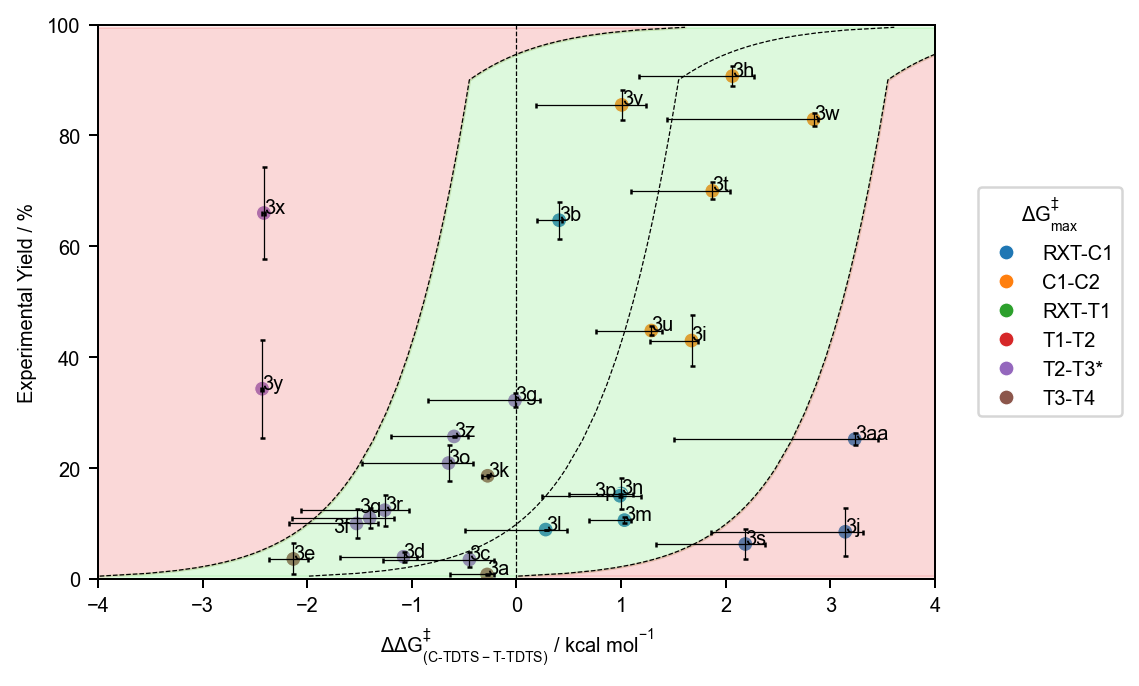

In [39]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=180)
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', '17-ts-t2-t3-corr_3.5', '20-ts-t3-t4']
equiv = 3.5

x = 'ideal_comp_ddgs_3.5'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', palette='tab10', ax=ax)
g6 = plt.errorbar(x=x, y=y, 
                    xerr=(main_barrier_df['ideal_comp_ddgs_3.5_minus'], main_barrier_df['ideal_comp_ddgs_3.5_plus']), 
                    yerr='nice_exp_error', 
                    data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] == '3p':
        ax.text(row[x]*0.75, row[y]*1, row['exp_name'], fontsize=8,)
    elif row['exp_name'] == '3q':
        ax.text(row[x]*1, row[y]*1.1, row['exp_name'], fontsize=8, ha='center')
    elif row['exp_name'] == '3f':
        ax.text(row[x]*1.15, row[y]*0.85, row['exp_name'], fontsize=8,)
    else:
        ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8,)


ax.set_xlabel('$\Delta\Delta$G$^{\u2021}_{(C\u2010TDTS-T\u2010TDTS)}$ / kcal mol$^{-1}$')
ax.set_ylabel('Experimental Yield / %')
ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([0, 100])
handles, labels = plt.gca().get_legend_handles_labels()

ddg_df['corrected_ddG_plus_2'] = ddg_df['corrected_ddG'] + 2
ddg_df['corrected_ddG_minus_2'] = ddg_df['corrected_ddG'] - 2

g = sns.lineplot(x='corrected_ddG', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_plus_2', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_minus_2', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')

x5 = ddg_df[ddg_df['equivalents']==equiv]['corrected_ddG_plus_2'].values
x1 = ddg_df[ddg_df['equivalents']==equiv]['corrected_ddG_minus_2'].values
y = ddg_df[ddg_df['equivalents']==equiv]['nice_yield'].values
plt.fill_betweenx(y=y, x1=-5, x2=x1, color='lightcoral', alpha=0.3)
plt.fill_betweenx(y=y, x1=x1, x2=x5, color='lightgreen', alpha=0.3)
plt.fill_betweenx(y=y, x1=x5, x2=5, color='lightcoral', alpha=0.3)


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left", title="$\Delta$G$^{\u2021}_{max}$").get_texts()
text_list[0].set_text('RXT-C1')
text_list[1].set_text('C1-C2')
text_list[2].set_text('RXT-T1')
text_list[3].set_text('T1-T2')
text_list[4].set_text('T2-T3*')
text_list[5].set_text('T3-T4')

ax.set_xlim([-4, 4])

plt.savefig('figures/figure8.png', transparent=True, bbox_inches="tight")

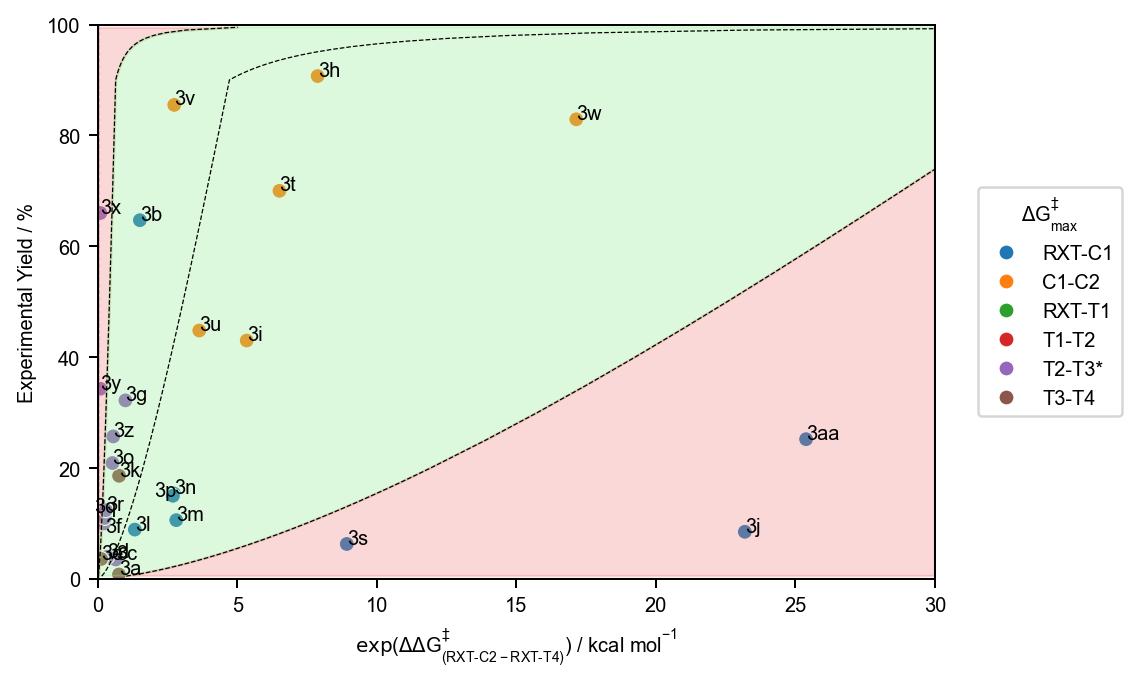

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=180)
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', '17-ts-t2-t3-corr_3.5', '20-ts-t3-t4']
equiv = 3.5

main_barrier_df['ideal_comp_ddgs_3.5_exp'] = np.exp(main_barrier_df['ideal_comp_ddgs_3.5'])
main_barrier_df['ideal_comp_ddgs_3.5_minus_exp'] = np.exp(main_barrier_df['ideal_comp_ddgs_3.5_minus'])
main_barrier_df['ideal_comp_ddgs_3.5_plus_exp'] = np.exp(main_barrier_df['ideal_comp_ddgs_3.5_plus'])


x = 'ideal_comp_ddgs_3.5_exp'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', palette='tab10', ax=ax)
#g6 = plt.errorbar(x=x, y=y, 
#                    xerr=(main_barrier_df['ideal_comp_ddgs_3.5_minus_exp'], main_barrier_df['ideal_comp_ddgs_3.5_plus_exp']), 
#                    yerr='nice_exp_error', 
#                    data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] == '3p':
        ax.text(row[x]*0.75, row[y]*1, row['exp_name'], fontsize=8,)
    elif row['exp_name'] == '3q':
        ax.text(row[x]*1, row[y]*1.1, row['exp_name'], fontsize=8, ha='center')
    elif row['exp_name'] == '3f':
        ax.text(row[x]*1.15, row[y]*0.85, row['exp_name'], fontsize=8,)
    else:
        ax.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8,)


ax.set_xlabel('$\exp(\Delta\Delta$G$^{\u2021}_{(RXT\u2010C2-RXT\u2010T4)})$ / kcal mol$^{-1}$')
ax.set_ylabel('Experimental Yield / %')
ax.axvline(0, linestyle='--', color='black', linewidth=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([0, 100])
handles, labels = plt.gca().get_legend_handles_labels()

ddg_df['corrected_ddG_plus_2'] = ddg_df['corrected_ddG'] + 2
ddg_df['corrected_ddG_minus_2'] = ddg_df['corrected_ddG'] - 2

ddg_df['corrected_ddG_exp'] = np.exp(ddg_df['corrected_ddG'])
ddg_df['corrected_ddG_plus_2_exp'] = np.exp(ddg_df['corrected_ddG_plus_2'])
ddg_df['corrected_ddG_minus_2_exp'] = np.exp(ddg_df['corrected_ddG_minus_2'])

g = sns.lineplot(x='corrected_ddG_exp', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_plus_2_exp', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')
g = sns.lineplot(x='corrected_ddG_minus_2_exp', y='nice_yield', data=ddg_df[ddg_df['equivalents']==equiv], c='black', ax=ax, linewidth=0.5, linestyle='--')

x5 = ddg_df[ddg_df['equivalents']==equiv]['corrected_ddG_plus_2_exp'].values
x1 = ddg_df[ddg_df['equivalents']==equiv]['corrected_ddG_minus_2_exp'].values
y = ddg_df[ddg_df['equivalents']==equiv]['nice_yield'].values
plt.fill_betweenx(y=y, x1=0, x2=x1, color='lightcoral', alpha=0.3)
plt.fill_betweenx(y=y, x1=x1, x2=x5, color='lightgreen', alpha=0.3)
plt.fill_betweenx(y=y, x1=x5, x2=30, color='lightcoral', alpha=0.3)


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left", title="$\Delta$G$^{\u2021}_{max}$").get_texts()
text_list[0].set_text('RXT-C1')
text_list[1].set_text('C1-C2')
text_list[2].set_text('RXT-T1')
text_list[3].set_text('T1-T2')
text_list[4].set_text('T2-T3*')
text_list[5].set_text('T3-T4')

ax.set_xlim([0, 30])

plt.savefig('figures/figure8_exp.png', transparent=True, bbox_inches="tight")

## Supplementary Figure S56

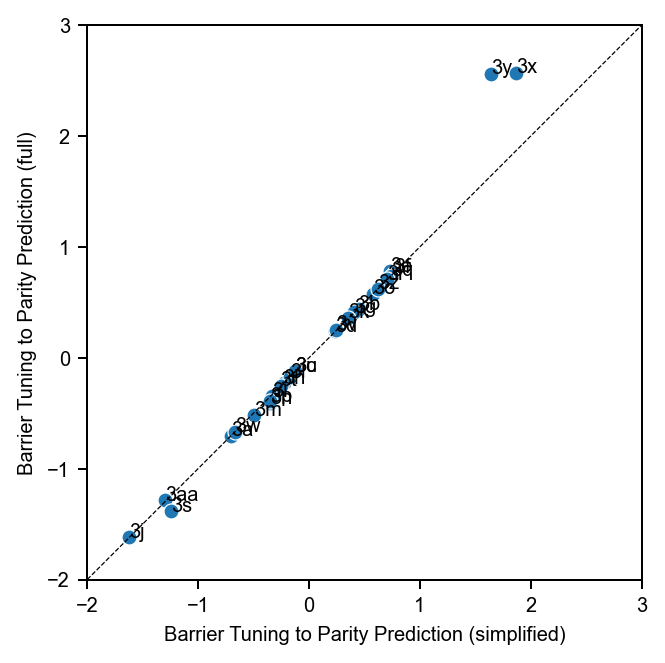

In [41]:
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-2, vmax=2,clip=False)

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=180)
g = sns.scatterplot(x='distances', y='barrier_tuning_to_parity_main', data=main_barrier_df, ax=ax, alpha=1)
ax.axline((0.0, 0.0), (1, 1), linestyle='--', color='black', linewidth=0.5)
ax.set_aspect('equal')

for _, row in main_barrier_df.iterrows():
        ax.text(row['distances']*1.0001, row['barrier_tuning_to_parity_main']*1.001, row['exp_name'], fontsize=8)

ax.set_xlim([-2, 3])
ax.set_ylim([-2, 3])
ax.set_xlabel("Barrier Tuning to Parity Prediction (simplified)")
ax.set_ylabel("Barrier Tuning to Parity Prediction (full)")

plt.savefig('figures/figures56.png', transparent=True, bbox_inches="tight")

In [42]:
s29_df = pd.read_csv("supplementary_table_s29.csv")
s29_part_df = main_barrier_df[['ligand_name', 'distances', 'barrier_tuning_to_parity_main']].copy()
# rename columns
s29_part_df.rename(columns={'ligand_name': 'ligand_name', 'distances': "Barrier Tuning to Parity Prediction (simplified)", "barrier_tuning_to_parity_main": "Barrier Tuning to Parity Prediction (full)"}, inplace=True)
# Merge s29_df and s29_part_df on ligand_name
s29_df = s29_df.merge(s29_part_df, on='ligand_name')
s29_df.to_csv("supplementary_table_s29.csv", index=False)

In [43]:
obtain_bounds_for_ddg_curves = False

if obtain_bounds_for_ddg_curves:
    ddg_df = pd.read_csv("ddg_curves.csv")
    for i, row in ddg_df.iterrows():
        equivalents = row['equivalents']
        correction = get_second_order_barrier_correction(concentration=0.02*equivalents, temperature=333.15)
        comp_yield_minus = get_yield_for_target_barrier(barrier=row['ddG']-2, equiv=equivalents, D_NAME='simplified')
        comp_yield_plus = get_yield_for_target_barrier(barrier=row['ddG']+2, equiv=equivalents, D_NAME='simplified')
        ddg_df.loc[i, 'comp_yield_minus'] = comp_yield_minus
        ddg_df.loc[i, 'comp_yield_plus'] = comp_yield_plus
        ddg_df.loc[i, 'nice_comp_yield_minus'] = comp_yield_minus*100
        ddg_df.loc[i, 'nice_comp_yield_plus'] = comp_yield_plus*100

    ddg_df.to_csv("ddg_curves.csv", index=False)
else:
    try:
        ddg_df = pd.read_csv("ddg_curves.csv")
    except FileNotFoundError:
        print("Obtain ddg curves! Approx 30 minutes")

/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/283620140.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar


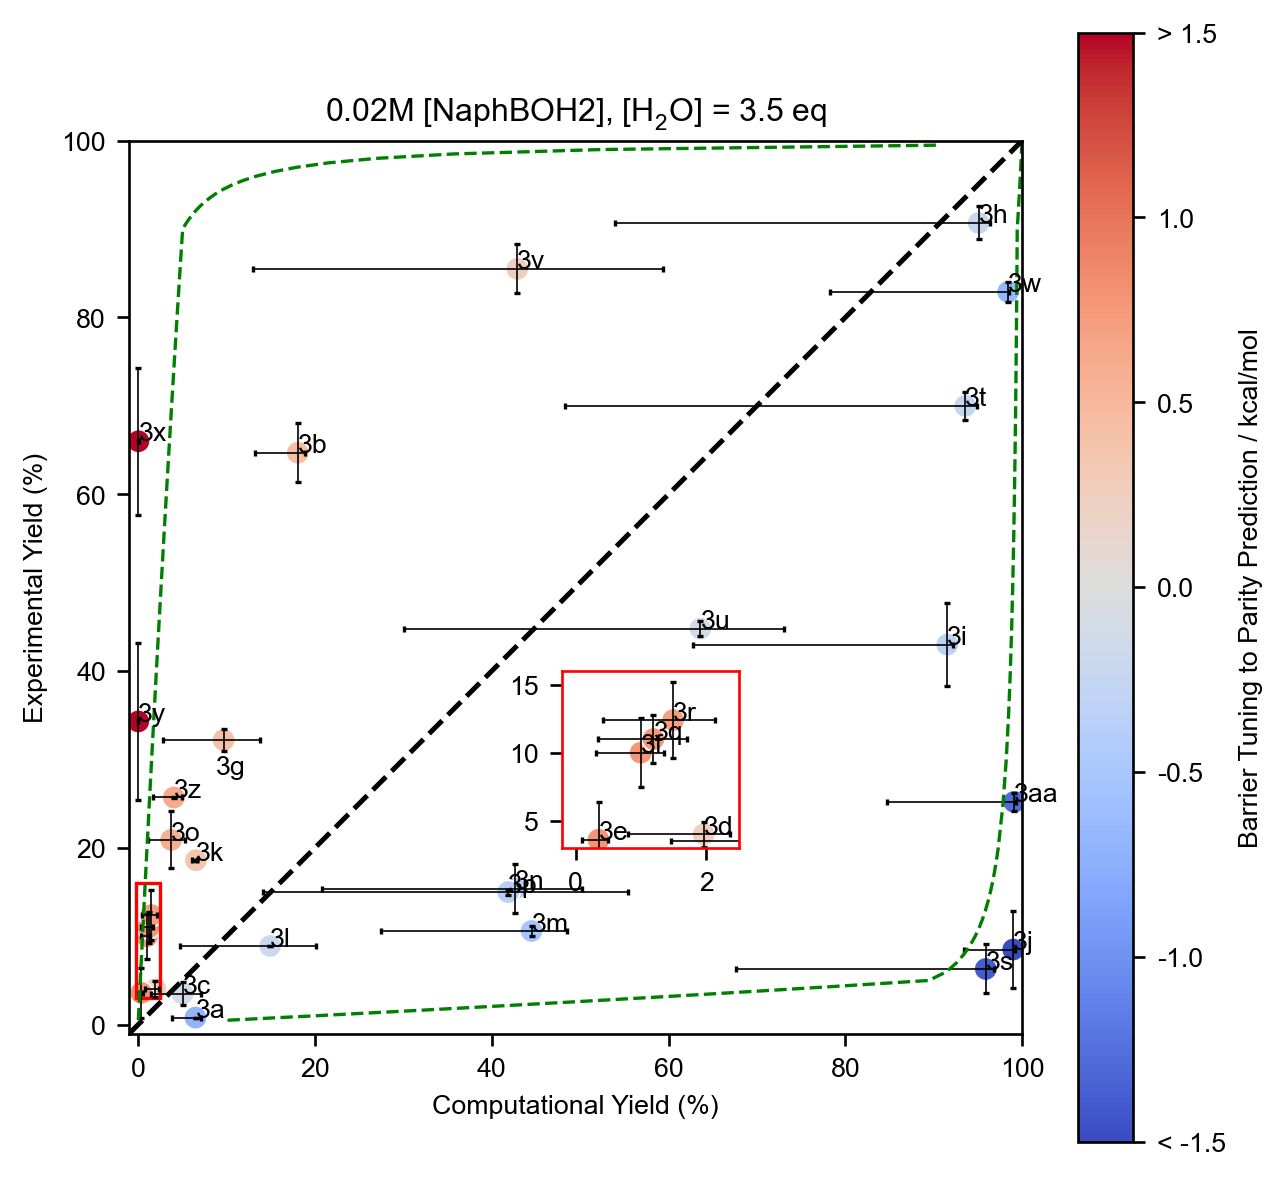

In [ ]:
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5,clip=False)

main_df = barrier_df[~barrier_df['ligand_name'].str.contains('9')].copy()
ddg_10 = ddg_df[ddg_df['equivalents'] == 1.0].copy()
ddg_35 = ddg_df[ddg_df['equivalents'] == 3.5].copy()
ddg_50 = ddg_df[ddg_df['equivalents'] == 5.0].copy()
    
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=240)

g4 = sns.scatterplot(x='nice_comp_yield_3.5_main', y='nice_exp_yield', ax=ax, data=main_df, s=50,
                    hue_norm=norm, hue='barrier_tuning_to_parity_main', palette='coolwarm',
                    )
g5 = plt.errorbar(x='nice_comp_yield_3.5_main', y='nice_exp_yield', 
                    xerr=(main_df['nice_comp_yield_3.5_main_minus'], main_df['nice_comp_yield_3.5_main_plus']), 
                    yerr='nice_exp_error', 
                    data=main_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5)

g2 = sns.lineplot(x="nice_comp_yield_minus", y="nice_comp_yield", ax=ax, data=ddg_df[ddg_df['equivalents'] == 3.5], 
                    color='g', linestyle='--', linewidth=1)
g3 = sns.lineplot(x="nice_comp_yield_plus", y="nice_comp_yield", ax=ax, data=ddg_df[ddg_df['equivalents'] == 3.5], 
                    color='g', linestyle='--', linewidth=1)


ax.set_aspect('equal')
ax.set_xlim([-1,100])
ax.set_ylim([-1,100])


for _, row in main_df[(main_df['nice_exp_yield'] >= 16) | (main_df['nice_comp_yield_3.5_main'] >= 2)].iterrows():
    if row['exp_name'] == '3g':
        ax.text(row['nice_comp_yield_3.5_main']*0.91, row['nice_exp_yield']*0.88, row['exp_name'], fontsize=8)
    else:
        ax.text(row['nice_comp_yield_3.5_main']*1.0001, row['nice_exp_yield']*1.001, row['exp_name'], fontsize=8)

ax.axline((-10,-10), slope=1, linestyle='--', c='black')
ax.set_xlabel("Computational Yield (%)")
ax.set_ylabel("Experimental Yield (%)")

ax.set_title("0.02M [NaphBOH2], [H$_2$O] = 3.5 eq")
ax.get_legend().remove()

x_inset1_start = -0.2
x_inset1_end = 2.5
y_inset1_start = 3
y_inset1_end = 16

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
    
axin1 = ax.inset_axes([48, 20, 20, 20], transform=ax.transData)
#axin1 = ax.inset_axes([20, 47, 25, 30], transform=ax.transData)
g6 = sns.scatterplot(x='nice_comp_yield_3.5_main', y='nice_exp_yield', ax=axin1, data=main_df, s=50, 
                     hue_norm=norm, hue='barrier_tuning_to_parity_main', palette='coolwarm',
                    )
g7 = axin1.errorbar(x='nice_comp_yield_3.5_main', y='nice_exp_yield', 
                      xerr=(main_df['nice_comp_yield_3.5_main_minus'], main_df['nice_comp_yield_3.5_main_plus']), 
                      yerr='nice_exp_error', 
                      data=main_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5)

#g2 = sns.lineplot(x="nice_comp_yield_3.5_main_minus", y="nice_comp_yield", ax=axin1, data=ddg_df[ddg_df['equivalents'] == 3.5], 
#                    color='g', linestyle='--', linewidth=1)
#g3 = sns.lineplot(x="nice_comp_yield_3.5_main_plus", y="nice_comp_yield", ax=axin1, data=ddg_df[ddg_df['equivalents'] == 3.5], 
#                    color='g', linestyle='--', linewidth=1)
axin1.get_legend().remove()
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])
axin1.set_xlabel("")
axin1.set_ylabel("")

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                              label='barrier_tuning_to_parity_main', ax=ax)

cbar.ax.set_yticklabels(['< -1.5', '-1.0', '-0.5', '0.0', '0.5', '1.0', '> 1.5'])  # vertically oriented colorbar

cbar.ax.set_ylabel('Barrier Tuning to Parity Prediction / kcal/mol', )

for _, row in main_df[(main_df['nice_exp_yield'] <= 16) & (main_df['nice_comp_yield_3.5_main'] <= 2)].iterrows():
    if row['exp_name'] == '2g':
        axin1.text(row['nice_comp_yield_3.5_main']*0.91, row['nice_exp_yield']*1.401, row['exp_name'], fontsize=8)
    elif row['exp_name'] == '2e':
        axin1.text(row['nice_comp_yield_3.5_main']*1.0001, row['nice_exp_yield']*1.001, row['exp_name'], fontsize=8)
    else:
        axin1.text(row['nice_comp_yield_3.5_main']*1.0001, row['nice_exp_yield']*1.001, row['exp_name'], fontsize=8)

        
for spine in axin1.spines.values():
    spine.set_edgecolor('red')

## Supplementary Discussion S8

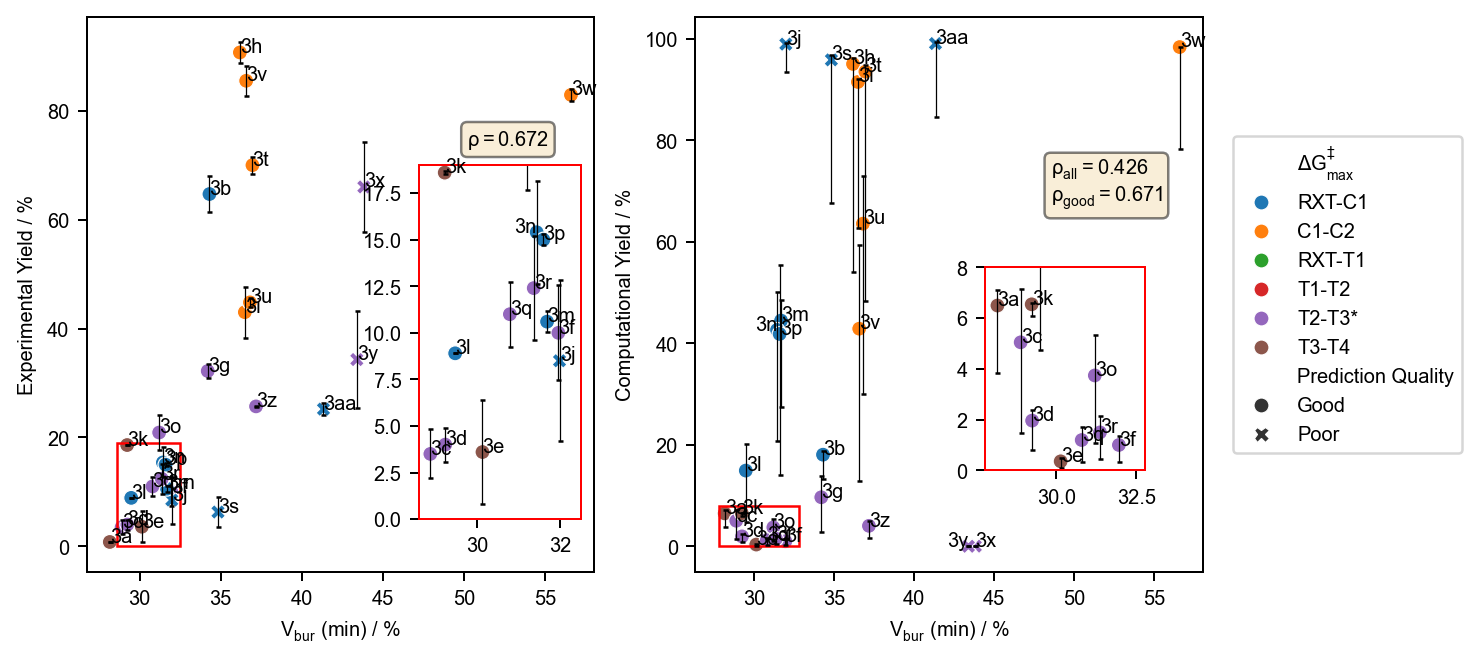

In [45]:
main_barrier_df['vbur_vbur_min_percent'] = main_barrier_df['vbur_vbur_min']/1.8

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
x = 'vbur_vbur_min_percent'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10', hue=f'max_overall_corr_{equiv}_name',  style=main_barrier_df['prediction_quality'], ax=ax[0])
g5 = ax[0].errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)

x_inset1_start = 51.5/1.8
x_inset1_end = 58.5/1.8
y_inset1_start = 0
y_inset1_end = 19

rect1 = mpl.patches.Rectangle((x_inset1_start, y_inset1_start), x_inset1_end-x_inset1_start, y_inset1_end-y_inset1_start, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)
    
axin1 = ax[0].inset_axes([85/1.8, 5, 18/1.8, 65], transform=ax[0].transData)
g_axin1 = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10',style=main_barrier_df['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=axin1)
g5 = axin1.errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin1.get_legend().set_visible(False)
axin1.set_xlim([x_inset1_start,x_inset1_end])
axin1.set_ylim([y_inset1_start,y_inset1_end])

for _, row in main_barrier_df.iterrows():
    if (axin1.get_xlim()[0] <= row[x] < axin1.get_xlim()[1]) & (axin1.get_ylim()[0] <= row[y] < axin1.get_ylim()[1]):
        if row['exp_name'] != '3n':
            axin1.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin1.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[0].set_xlabel("V$_{bur}$ (min) / %")
ax[0].set_ylabel("Experimental Yield / %")
axin1.set_xlabel("")
axin1.set_ylabel("")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.8, r'$\rho=%.3f$' % (pearsonr(main_barrier_df[y], main_barrier_df[x])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

x = 'vbur_vbur_min_percent'
y = f'nice_comp_yield_{equiv}_main'
g2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10',hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'], ax=ax[1])
g5 = ax[1].errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2_goleft = ['3n', '3y']
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] not in axin2_goleft:
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

x_inset2_start = 50/1.8
x_inset2_end = 59/1.8
y_inset2_start = 0
y_inset2_end = 8

rect2 = mpl.patches.Rectangle((x_inset2_start, y_inset2_start), x_inset2_end-x_inset2_start, y_inset2_end-y_inset2_start, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
        
        
axin2 = ax[1].inset_axes([80/1.8, 15, 18/1.8, 40], transform=ax[1].transData)
g_axin2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10', hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'],ax=axin2)
g5 = axin2.errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2.get_legend().set_visible(False)
axin2.set_xlim([x_inset2_start,x_inset2_end])
axin2.set_ylim([y_inset2_start,y_inset2_end])


for _, row in main_barrier_df.iterrows():
    if (axin2.get_xlim()[0] <= row[x] < axin2.get_xlim()[1]) & (axin2.get_ylim()[0] <= row[y] < axin2.get_ylim()[1]):
        if row['exp_name'] not in axin2_goleft:
            axin2.text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            axin2.text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (min) / %")
ax[1].set_ylabel("Computational Yield / %")
axin2.set_xlabel("")
axin2.set_ylabel("")

all_r = pearsonr(main_barrier_df[x], main_barrier_df[y])[0]
di = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
good_r = pearsonr(di[x], di[y])[0]
#dg = ff[ff['vbur_near_vbur_min_percent'] <= 75]
dh = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
some_r = pearsonr(dh[x], dh[y])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('figures/figure11.png', transparent=True, bbox_inches="tight")

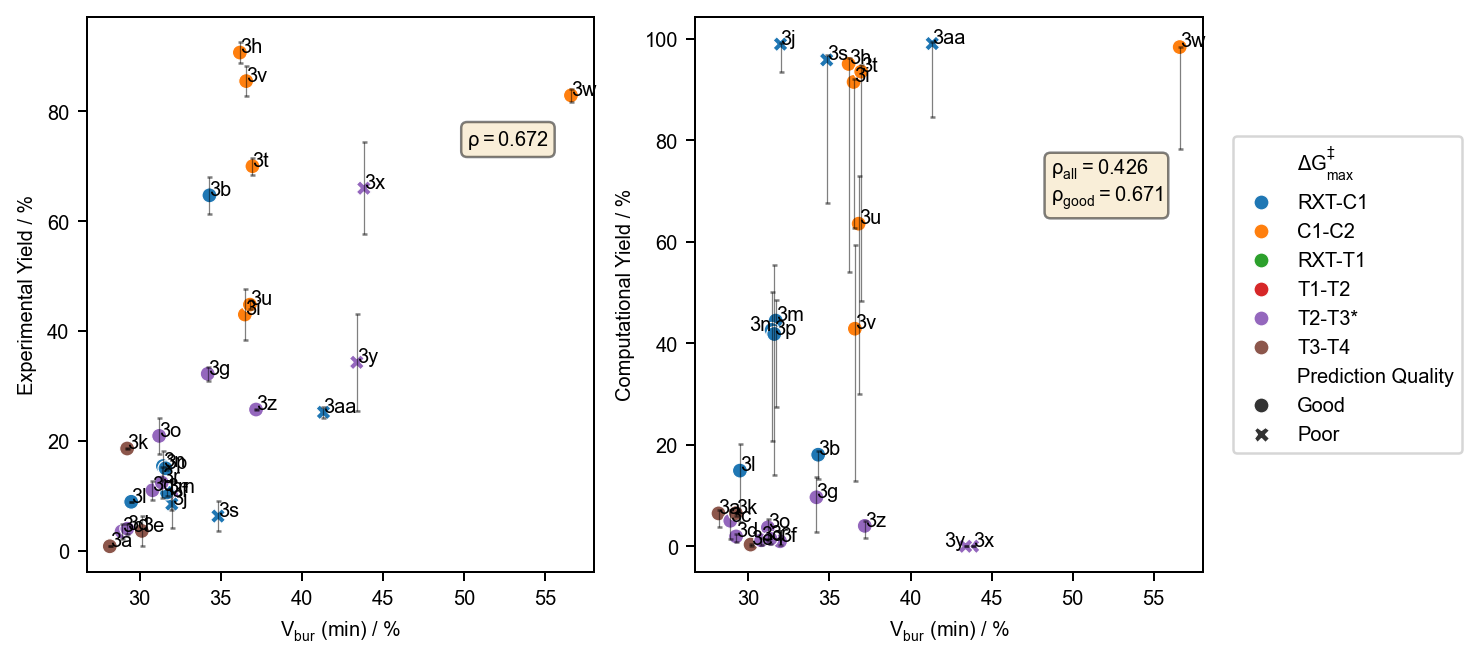

In [50]:
main_barrier_df['vbur_vbur_min_percent'] = main_barrier_df['vbur_vbur_min']/1.8

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
x = 'vbur_vbur_min_percent'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10', hue=f'max_overall_corr_{equiv}_name',  style=main_barrier_df['prediction_quality'], ax=ax[0])
g5 = ax[0].errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, alpha=0.5, label='_nolegend_')
for _, row in main_barrier_df.iterrows():
    ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)

ax[0].get_legend().set_visible(False)

ax[0].set_xlabel("V$_{bur}$ (min) / %")
ax[0].set_ylabel("Experimental Yield / %")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.75, 0.8, r'$\rho=%.3f$' % (pearsonr(main_barrier_df[y], main_barrier_df[x])[0]),
           transform=ax[0].transAxes, verticalalignment='top', bbox=props)

x = 'vbur_vbur_min_percent'
y = f'nice_comp_yield_{equiv}_main'
g2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10',hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'], ax=ax[1])
g5 = ax[1].errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, alpha=0.5, label='_nolegend_')
axin2_goleft = ['3n', '3y']
for _, row in main_barrier_df.iterrows():
    if row['exp_name'] not in axin2_goleft:
        ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    else:
        ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (min) / %")
ax[1].set_ylabel("Computational Yield / %")

all_r = pearsonr(main_barrier_df[x], main_barrier_df[y])[0]
di = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
good_r = pearsonr(di[x], di[y])[0]
#dg = ff[ff['vbur_near_vbur_min_percent'] <= 75]
dh = main_barrier_df[main_barrier_df['prediction_quality'] == 'Good']
some_r = pearsonr(dh[x], dh[y])[0]


ax[1].text(0.7, 0.75, rf"$\rho_{{all}}={all_r:.3f}$"+"\n"+rf"$\rho_{{good}}={some_r:.3f}$", transform=ax[1].transAxes, verticalalignment='top', bbox=props)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

plt.savefig('figures/figure11.png', transparent=True, bbox_inches="tight")

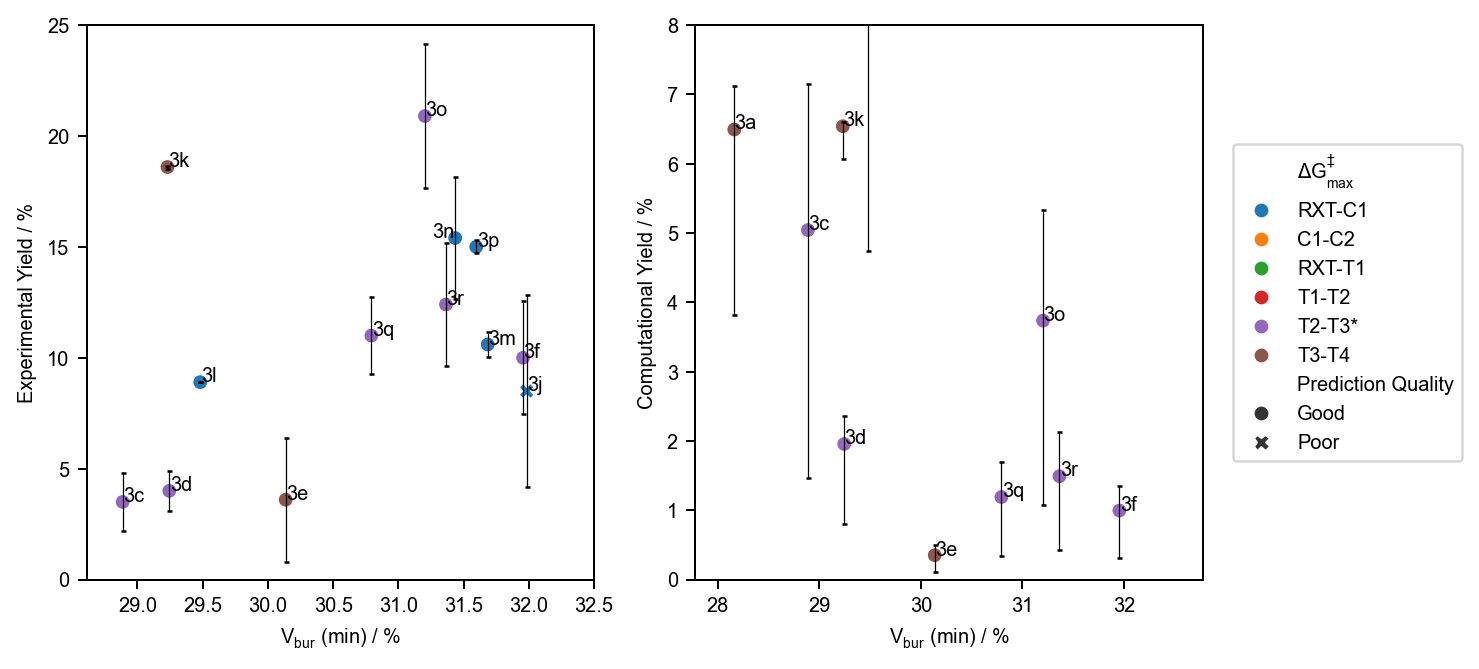

In [51]:
main_barrier_df['vbur_vbur_min_percent'] = main_barrier_df['vbur_vbur_min']/1.8

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=180)
x = 'vbur_vbur_min_percent'
y = 'nice_exp_yield'
g = sns.scatterplot(x=x, y=y, data=main_barrier_df, hue_order=hue_order, palette='tab10', hue=f'max_overall_corr_{equiv}_name',  style=main_barrier_df['prediction_quality'], ax=ax[0])
g5 = ax[0].errorbar(x=x, y=y, yerr='nice_exp_error', data=main_barrier_df, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')

ax[0].get_legend().set_visible(False)

x_inset1_start = 51.5/1.8
x_inset1_end = 58.5/1.8
y_inset1_start = 0
y_inset1_end = 25

ax[0].set_xlim([x_inset1_start,x_inset1_end])
ax[0].set_ylim([y_inset1_start,y_inset1_end])

for _, row in main_barrier_df.iterrows():
    if (ax[0].get_xlim()[0] <= row[x] < ax[0].get_xlim()[1]) & (ax[0].get_ylim()[0] <= row[y] < ax[0].get_ylim()[1]):
        if row['exp_name'] != '3n':
            ax[0].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            ax[0].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')



ax[0].set_xlabel("V$_{bur}$ (min) / %")
ax[0].set_ylabel("Experimental Yield / %")

x = 'vbur_vbur_min_percent'
y = f'nice_comp_yield_{equiv}_main'
g2 = sns.scatterplot(x=x, y=y, data=main_barrier_df, palette='tab10',hue_order=hue_order, hue=f'max_overall_corr_{equiv}_name', style=main_barrier_df['prediction_quality'], ax=ax[1])
g5 = ax[1].errorbar(x=x, y=y, yerr=(main_barrier_df[f'nice_comp_yield_{equiv}_main_minus'], main_barrier_df[f'nice_comp_yield_{equiv}_main_plus']), data=main_barrier_df, 
                  fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
axin2_goleft = ['3n', '3y']

x_inset2_start = 50/1.8
x_inset2_end = 59/1.8
y_inset2_start = 0
y_inset2_end = 8
        
ax[1].set_xlim([x_inset2_start,x_inset2_end])
ax[1].set_ylim([y_inset2_start,y_inset2_end])


for _, row in main_barrier_df.iterrows():
    if (ax[1].get_xlim()[0] <= row[x] < ax[1].get_xlim()[1]) & (ax[1].get_ylim()[0] <= row[y] < ax[1].get_ylim()[1]):
        if row['exp_name'] not in axin2_goleft:
            ax[1].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
        else:
            ax[1].text(row[x]*0.9999, row[y]*1.001, row['exp_name'], fontsize=8, ha='right')

ax[1].set_xlabel("V$_{bur}$ (min) / %")
ax[1].set_ylabel("Computational Yield / %")


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6,7,8,9]
text_list = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')
#text_list[8].set_text()
#text_list[9].set_text()

for spine in axin1.spines.values():
    spine.set_edgecolor('r')
    
for spine in axin2.spines.values():
    spine.set_edgecolor('r')

plt.savefig('figures/figures137.png', transparent=True, bbox_inches="tight")

## Correlation analysis

In [52]:
from scipy.stats import pearsonr

kraken_columns = [
    'dipolemoment_boltz', 'dipolemoment_delta', 'dipolemoment_max',
    'dipolemoment_min', 'dipolemoment_vburminconf', 'E_oxidation_boltz',
    'E_reduction_boltz', 'E_solv_cds_boltz', 'E_solv_elstat_boltz',
    'E_solv_total_boltz', 'efg_amp_P_boltz', 'efgtens_xx_P_boltz',
    'efgtens_yy_P_boltz', 'efgtens_zz_P_boltz', 'fmo_e_homo_boltz',
    'fmo_e_lumo_boltz', 'fmo_eta_boltz', 'fmo_mu_boltz', 'fmo_omega_boltz',
    'fukui_m_boltz', 'fukui_p_boltz', 'nbo_bd_e_avg_boltz', 'nbo_bd_e_max_boltz',
    'nbo_bd_occ_avg_boltz', 'nbo_bd_occ_min_boltz', 'nbo_bds_e_avg_boltz',
    'nbo_bds_e_min_boltz', 'nbo_bds_occ_avg_boltz', 'nbo_bds_occ_max_boltz',
    'nbo_lp_P_e_boltz', 'nbo_lp_P_occ_boltz', 'nbo_lp_P_percent_s_boltz',
    'nbo_P_boltz', 'nbo_P_ra_boltz', 'nbo_P_rc_boltz', 'nmr_P_boltz',
    'nmrtens_sxx_P_boltz', 'nmrtens_syy_P_boltz', 'nmrtens_szz_P_boltz',
    'nuesp_P_boltz', 'Pint_dP_boltz', 'Pint_P_int_boltz', 'Pint_P_max_boltz',
    'Pint_P_min_boltz', 'pyr_alpha_boltz', 'pyr_alpha_delta', 'pyr_alpha_max',
    'pyr_alpha_min', 'pyr_alpha_vburminconf', 'pyr_P_boltz', 'pyr_P_delta',
    'pyr_P_max', 'pyr_P_min', 'pyr_P_vburminconf', 'qpole_amp_boltz',
    'qpole_amp_delta', 'qpole_amp_max', 'qpole_amp_min', 'qpole_amp_vburminconf',
    'qpoletens_xx_boltz', 'qpoletens_xx_delta', 'qpoletens_xx_max',
    'qpoletens_xx_min', 'qpoletens_xx_vburminconf', 'qpoletens_yy_boltz',
    'qpoletens_yy_delta', 'qpoletens_yy_max', 'qpoletens_yy_min',
    'qpoletens_yy_vburminconf', 'qpoletens_zz_boltz', 'qpoletens_zz_delta',
    'qpoletens_zz_max', 'qpoletens_zz_min', 'qpoletens_zz_vburminconf',
    'somo_ra_boltz', 'somo_rc_boltz', 'sphericity_boltz', 'spindens_P_ra_boltz',
    'spindens_P_rc_boltz', 'sterimol_B1_boltz', 'sterimol_B1_delta',
    'sterimol_B1_max', 'sterimol_B1_min', 'sterimol_B1_vburminconf',
    'sterimol_B5_boltz', 'sterimol_B5_delta', 'sterimol_B5_max', 'sterimol_B5_min',
    'sterimol_B5_vburminconf', 'sterimol_burB1_boltz', 'sterimol_burB1_delta',
    'sterimol_burB1_max', 'sterimol_burB1_min', 'sterimol_burB1_vburminconf',
    'sterimol_burB5_boltz', 'sterimol_burB5_delta', 'sterimol_burB5_max',
    'sterimol_burB5_min', 'sterimol_burB5_vburminconf', 'sterimol_burL_boltz',
    'sterimol_burL_delta', 'sterimol_burL_max', 'sterimol_burL_min',
    'sterimol_burL_vburminconf', 'sterimol_L_boltz', 'sterimol_L_delta',
    'sterimol_L_max', 'sterimol_L_min', 'sterimol_L_vburminconf',
    'surface_area_boltz', 'vbur_far_vbur_boltz', 'vbur_far_vbur_delta',
    'vbur_far_vbur_max', 'vbur_far_vbur_min', 'vbur_far_vbur_vburminconf',
    'vbur_far_vtot_boltz', 'vbur_far_vtot_delta', 'vbur_far_vtot_max',
    'vbur_far_vtot_min', 'vbur_far_vtot_vburminconf', 'vbur_max_delta_qvbur_boltz',
    'vbur_max_delta_qvbur_delta', 'vbur_max_delta_qvbur_max',
    'vbur_max_delta_qvbur_min', 'vbur_max_delta_qvbur_vburminconf',
    'vbur_max_delta_qvtot_boltz', 'vbur_max_delta_qvtot_delta',
    'vbur_max_delta_qvtot_max', 'vbur_max_delta_qvtot_min',
    'vbur_max_delta_qvtot_vburminconf', 'vbur_near_vbur_boltz',
    'vbur_near_vbur_delta', 'vbur_near_vbur_max', 'vbur_near_vbur_min',
    'vbur_near_vbur_vburminconf', 'vbur_near_vtot_boltz', 'vbur_near_vtot_delta',
    'vbur_near_vtot_max', 'vbur_near_vtot_min', 'vbur_near_vtot_vburminconf',
    'vbur_ovbur_max_boltz', 'vbur_ovbur_max_delta', 'vbur_ovbur_max_max',
    'vbur_ovbur_max_min', 'vbur_ovbur_max_vburminconf', 'vbur_ovbur_min_boltz',
    'vbur_ovbur_min_delta', 'vbur_ovbur_min_max', 'vbur_ovbur_min_min',
    'vbur_ovbur_min_vburminconf', 'vbur_ovtot_max_boltz', 'vbur_ovtot_max_delta',
    'vbur_ovtot_max_max', 'vbur_ovtot_max_min', 'vbur_ovtot_max_vburminconf',
    'vbur_ovtot_min_boltz', 'vbur_ovtot_min_delta', 'vbur_ovtot_min_max',
    'vbur_ovtot_min_min', 'vbur_ovtot_min_vburminconf', 'vbur_qvbur_max_boltz',
    'vbur_qvbur_max_delta', 'vbur_qvbur_max_max', 'vbur_qvbur_max_min',
    'vbur_qvbur_max_vburminconf', 'vbur_qvbur_min_boltz', 'vbur_qvbur_min_delta',
    'vbur_qvbur_min_max', 'vbur_qvbur_min_min', 'vbur_qvbur_min_vburminconf',
    'vbur_qvtot_max_boltz', 'vbur_qvtot_max_delta', 'vbur_qvtot_max_max',
    'vbur_qvtot_max_min', 'vbur_qvtot_max_vburminconf', 'vbur_qvtot_min_boltz',
    'vbur_qvtot_min_delta', 'vbur_qvtot_min_max', 'vbur_qvtot_min_min',
    'vbur_qvtot_min_vburminconf', 'vbur_ratio_vbur_vtot_boltz', 'vbur_vbur_boltz',
    'vbur_vbur_delta', 'vbur_vbur_max', 'vbur_vbur_min', 'vbur_vbur_vburminconf',
    'vbur_vtot_boltz', 'vmin_r_boltz', 'vmin_vmin_boltz', 'volume_boltz'
]

equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

kraken_full = main_barrier_df[['ligand_name', 'exp_name', 'prediction_quality', f'max_overall_corr_{equiv}_name', 'nice_exp_yield', 'nice_exp_error', f'nice_comp_yield_{equiv}_main', f'nice_comp_yield_{equiv}_main_minus', f'nice_comp_yield_{equiv}_main_plus']+kraken_columns].copy()

kraken_good = main_barrier_df[main_barrier_df['prediction_quality'] == "Good"].copy()


In [53]:
get_correlation = True

if get_correlation:
    exp_full_corr_dict = {}
    exp_good_corr_dict = {}
    comp_full_corr_dict = {}
    comp_good_corr_dict = {}
    for descriptor in kraken_columns:
        exp_full_corr_dict[descriptor] = pearsonr(kraken_full[descriptor], kraken_full['nice_exp_yield'])[0]
        exp_good_corr_dict[descriptor] = pearsonr(kraken_good[descriptor], kraken_good['nice_exp_yield'])[0]
        comp_full_corr_dict[descriptor] = pearsonr(kraken_full[descriptor], kraken_full['nice_comp_yield_3.5_main'])[0]
        comp_good_corr_dict[descriptor] = pearsonr(kraken_good[descriptor], kraken_good['nice_comp_yield_3.5_main'])[0]
        
    corr_df = pd.DataFrame(data=[exp_full_corr_dict,exp_good_corr_dict,comp_full_corr_dict,comp_good_corr_dict,]).T

    corr_df.columns = ['exp_full', 'exp_good', 'comp_full', 'comp_good']
    for col in corr_df.columns:
        corr_df[col+'_abs'] = corr_df[col].abs()
        corr_df[col+'_abs_rank'] = corr_df[col+'_abs'].rank(ascending=False)

    corr_df.index.names = ['descriptor']
    corr_df.to_csv('corr_dict.csv')
    corr_df = pd.read_csv('corr_dict.csv')
else:
    try:
        corr_df = pd.read_csv('corr_dict.csv')
    except FileNotFoundError:
        print("Run correlation analysis!")

/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1535516632.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  exp_full_corr_dict[descriptor] = pearsonr(kraken_full[descriptor], kraken_full['nice_exp_yield'])[0]
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1535516632.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  exp_good_corr_dict[descriptor] = pearsonr(kraken_good[descriptor], kraken_good['nice_exp_yield'])[0]
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1535516632.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  comp_full_corr_dict[descriptor] = pearsonr(kraken_full[descriptor], kraken_full['nice_comp_yield_3.5_main'])[0]
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1535516632.py:12: ConstantInputWarning: An input array is constant; the correlation c

# Supplementary Figure S104

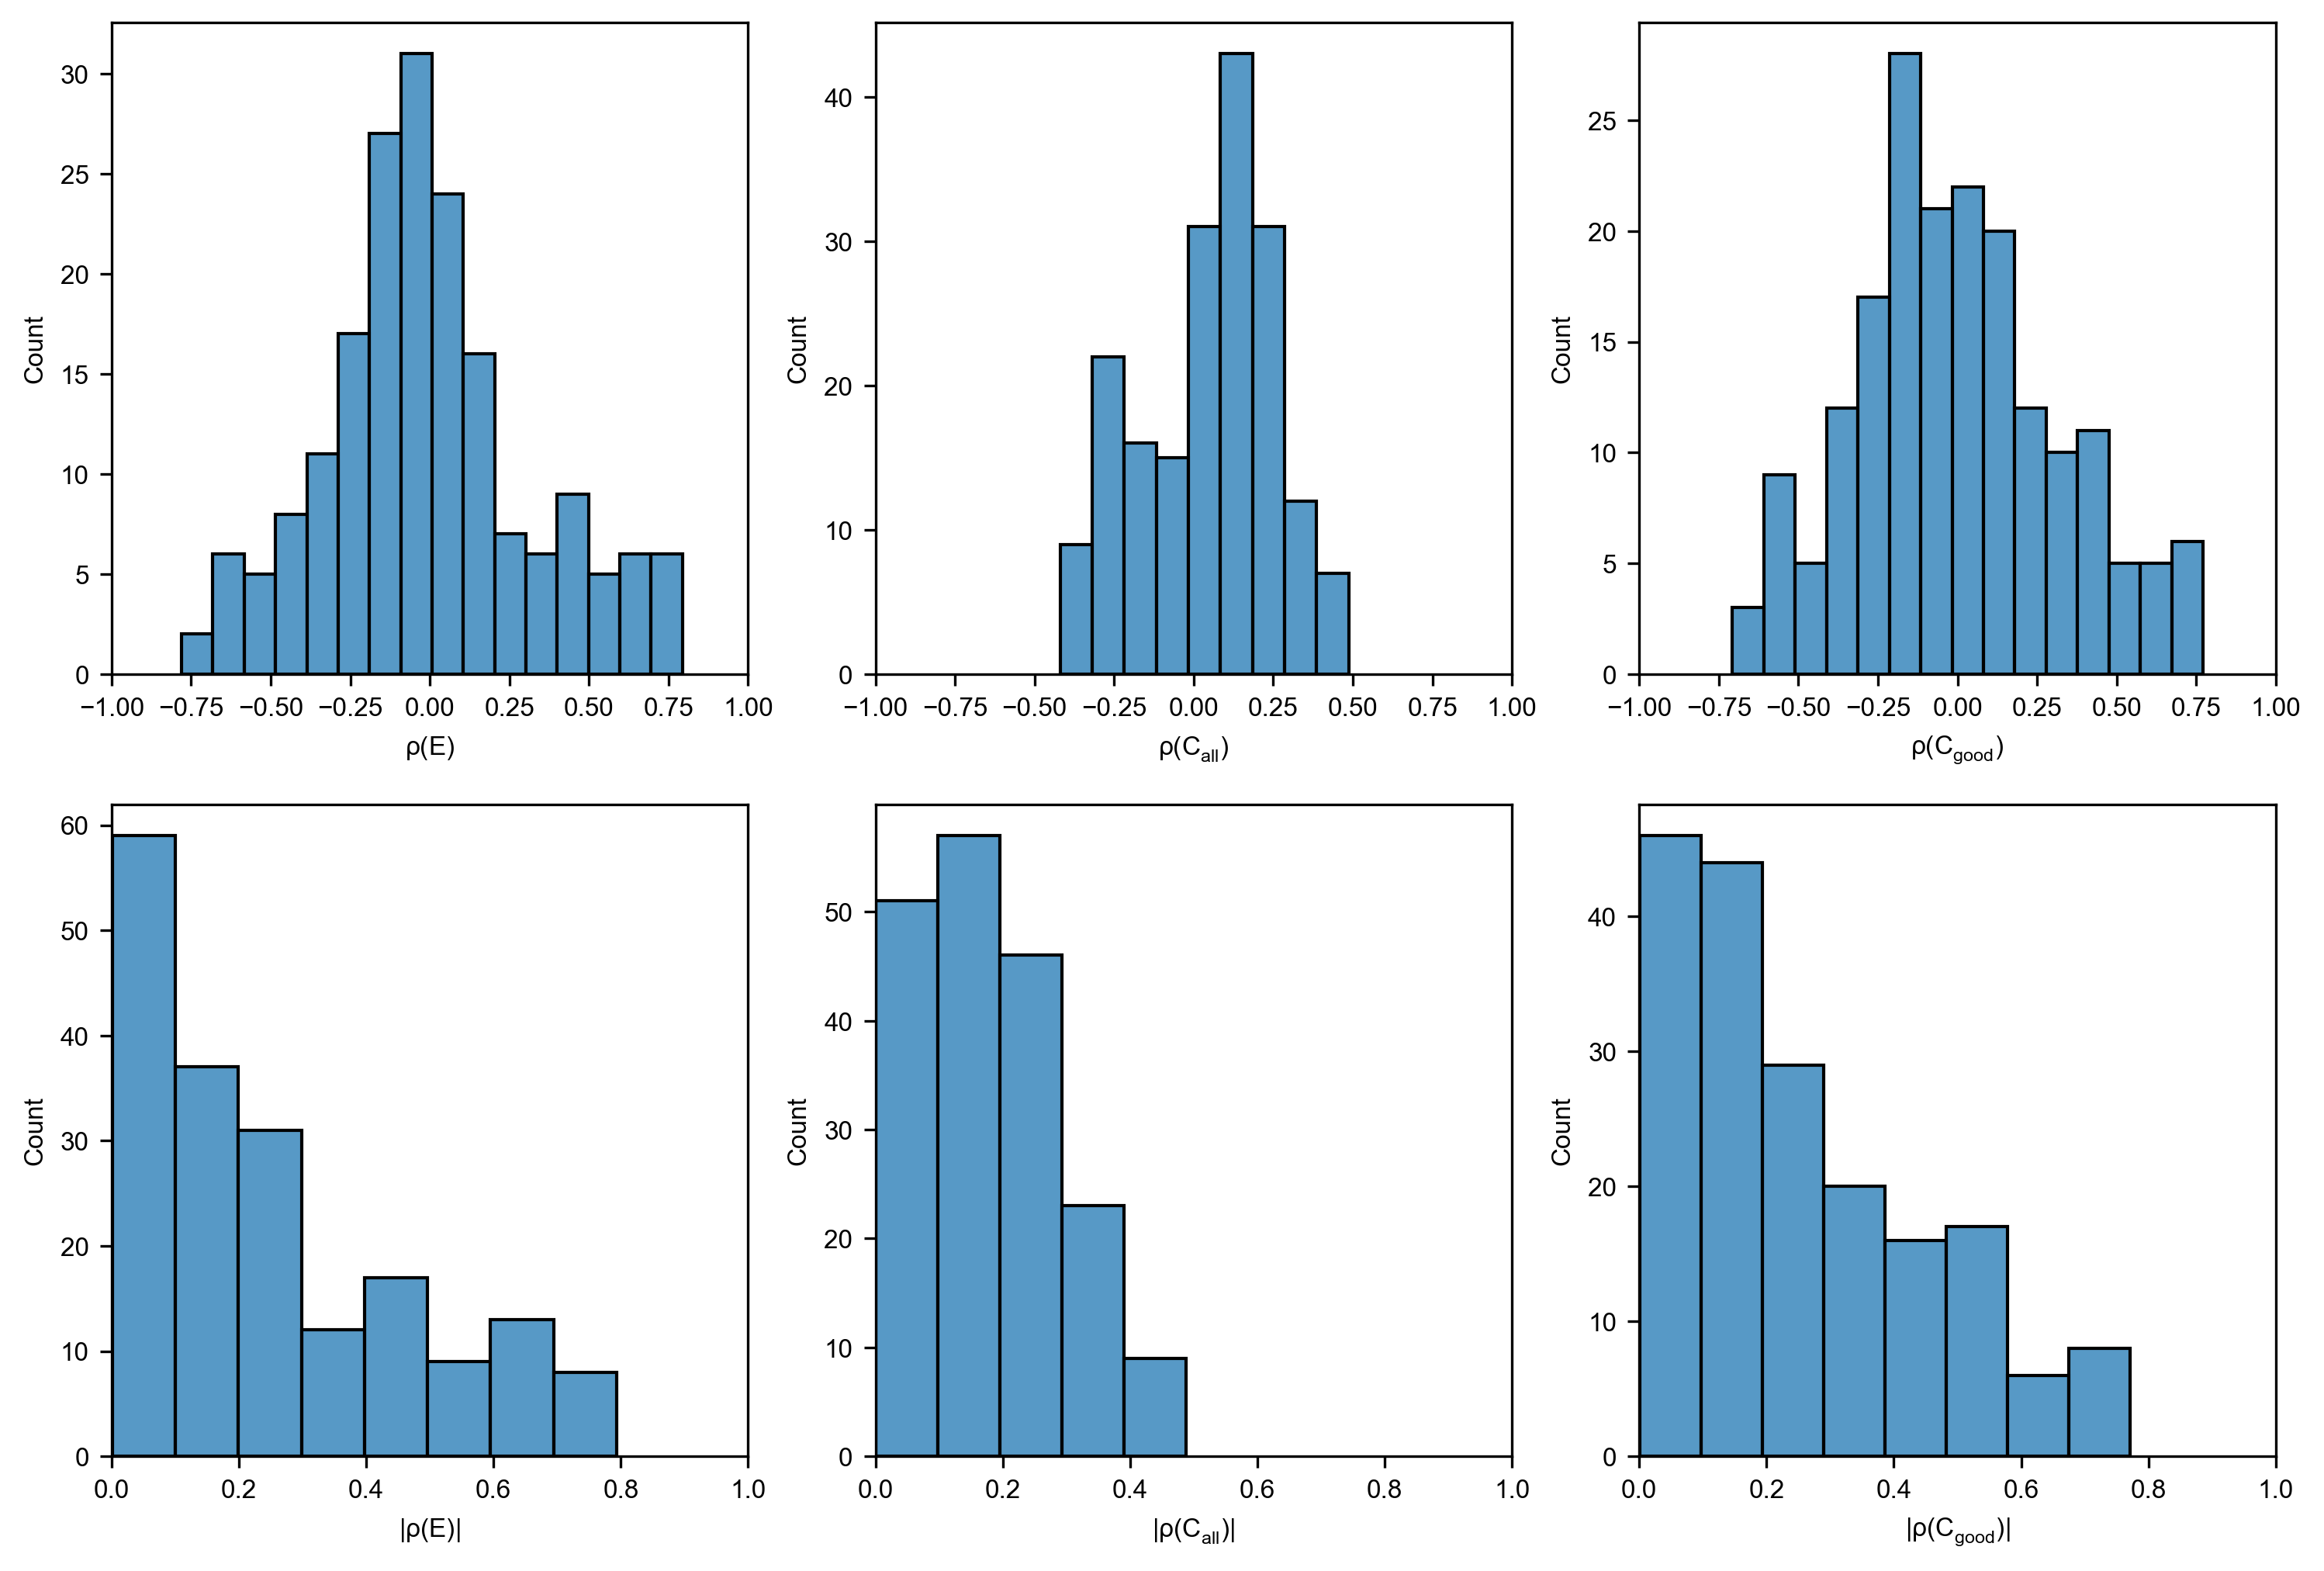

In [54]:
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows,ncols, figsize=(12,8), dpi=300)

axis_names = [[r"$\rho(E)$", r"$\rho(C_{all})$", r"$\rho(C_{good})$"],[r"$|\rho(E)|$", r"$|\rho(C_{all})|$", r"$|\rho(C_{good})|$"]]

desired_axes = ['exp_full', 'comp_full', 'comp_good', 'exp_full_abs', 'comp_full_abs', 'comp_good_abs', ]

for k, col in enumerate(desired_axes):
    i = k // ncols
    j = k % ncols
    sns.histplot(x=corr_df[col], data=corr_df, ax=ax[i][j], binwidth=0.1)
    if i == 1:
        ax[i][j].set_xlim([0, 1])
    else:
        ax[i][j].set_xlim([-1, 1])
    ax[i][j].set_xlabel(axis_names[i][j])

plt.savefig("figures/figures104.png", transparent=True, bbox_inches='tight')

/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/2953249959.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/2953249959.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/2953249959.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d

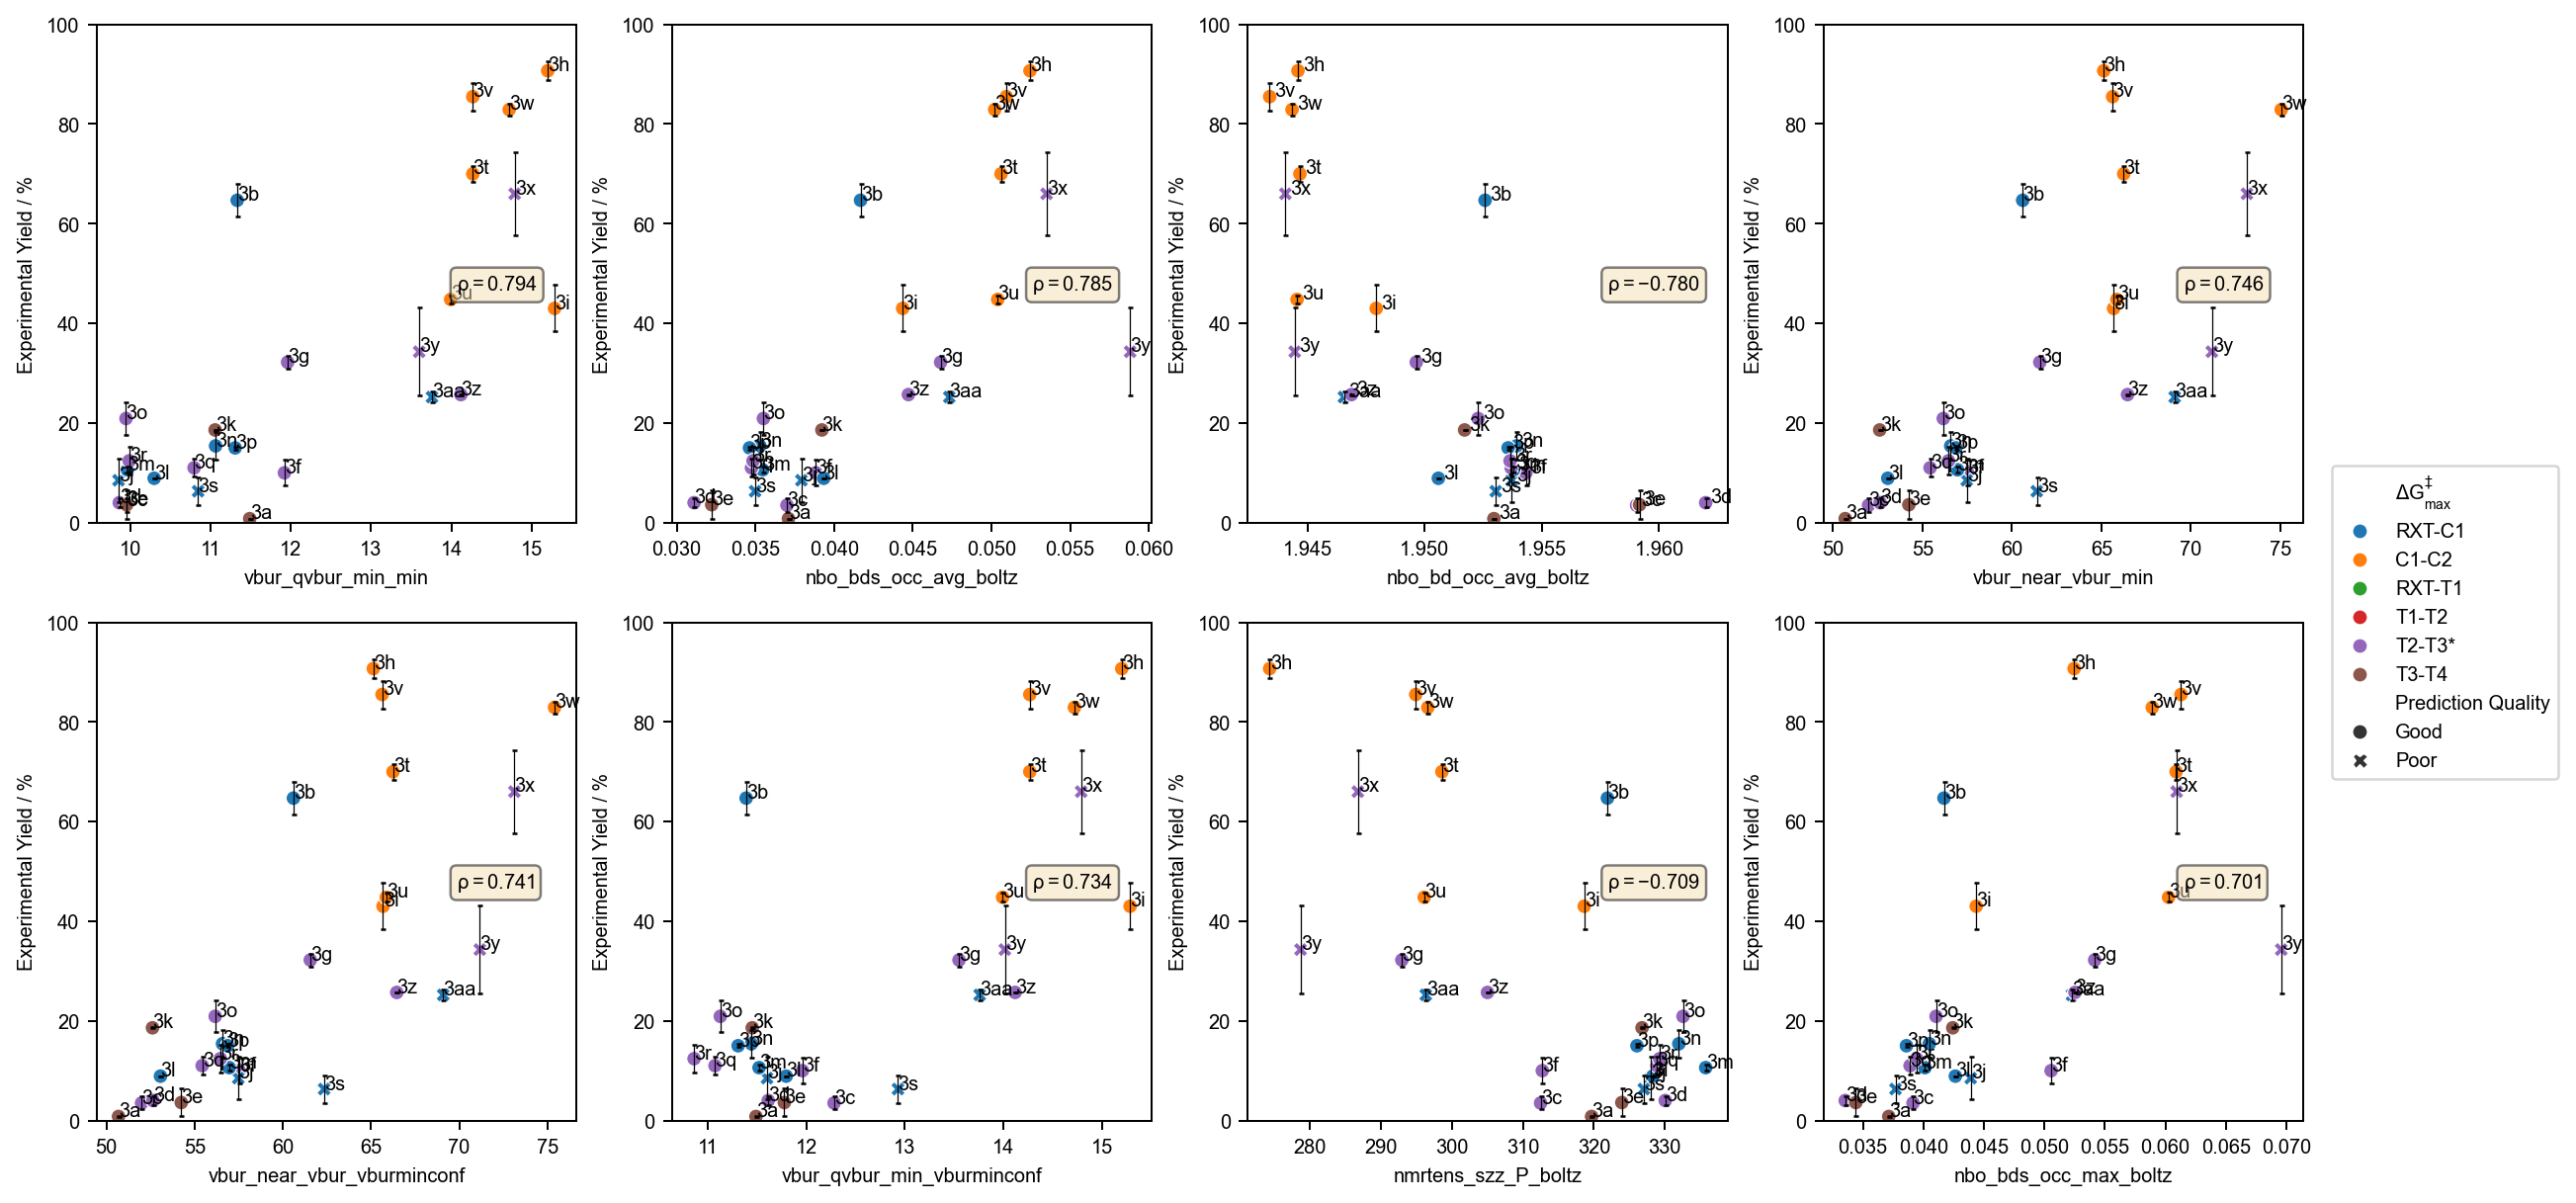

In [55]:
interest = 'exp_full'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
corr_df_tmp = corr_df.sort_values(by='exp_full_abs_rank',ascending=True).head(8)

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(16,8), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

for n, col in enumerate(corr_df_tmp['descriptor']):
    i = n // ncols
    j = n % ncols
    x = col
    y = 'nice_exp_yield'
    g = sns.scatterplot(x=x, y=y, data=kraken_full, hue_order=hue_order, palette='tab10', style=kraken_full['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=ax[i][j])
    g5 = ax[i][j].errorbar(x=x, y=y, yerr='nice_exp_error', data=kraken_full, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
    for _, row in kraken_full.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")
    ax[i][j].set_ylim(0,100)


text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')



plt.savefig("figures/figures101.png", transparent=True, bbox_inches='tight')

/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/2202360687.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/2202360687.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/2202360687.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d

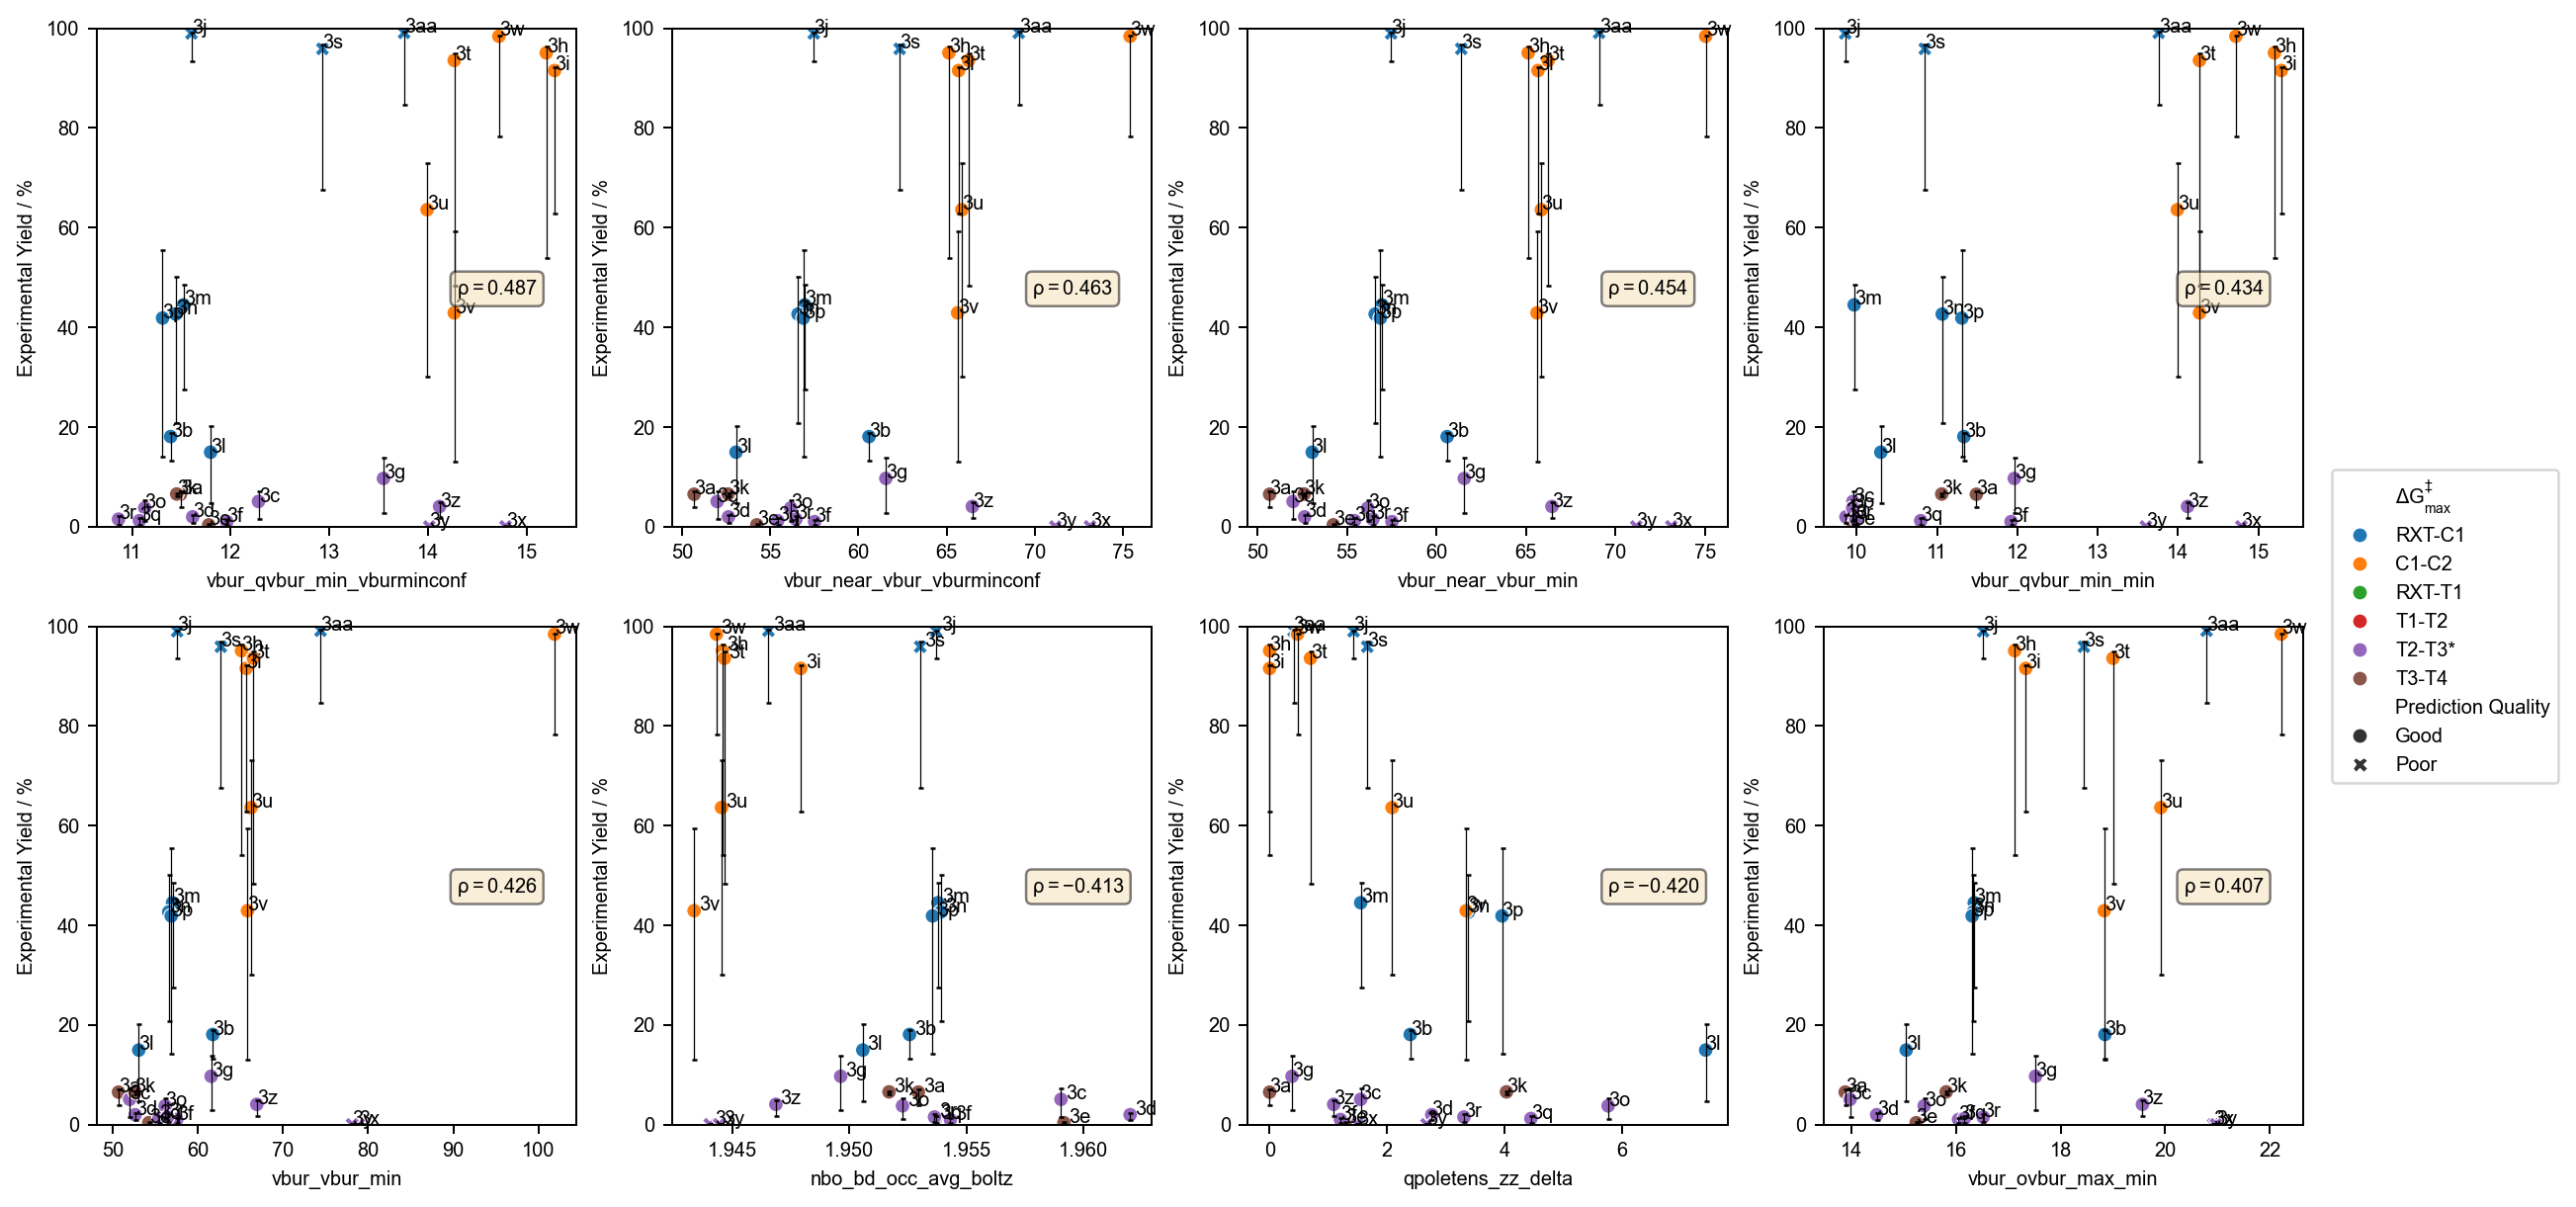

In [56]:
interest = 'comp_full'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
corr_df_tmp = corr_df.sort_values(by='comp_full_abs_rank',ascending=True).head(8)

# vbur_vbur_vburminconf is equal to vbur_vbur_min
descriptor_list = ['vbur_qvbur_min_vburminconf',
 'vbur_near_vbur_vburminconf',
 'vbur_near_vbur_min',
 'vbur_qvbur_min_min',
 'vbur_vbur_min',
 'nbo_bd_occ_avg_boltz',
 'qpoletens_zz_delta',
 'vbur_ovbur_max_min',]

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(16,8), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

for n, col in enumerate(descriptor_list):
    i = n // ncols
    j = n % ncols
    x = col
    y = f'nice_comp_yield_{equiv}_main'
    g = sns.scatterplot(x=x, y=y, data=kraken_full, hue_order=hue_order, palette='tab10', style=kraken_full['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=ax[i][j])
    g5 = ax[i][j].errorbar(x=x, y=y, yerr=(kraken_full[f'nice_comp_yield_{equiv}_main_minus'], kraken_full[f'nice_comp_yield_{equiv}_main_plus']), data=kraken_full, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
    for _, row in kraken_full.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")
    ax[i][j].set_ylim(0,100)


text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("figures/figures102.png", transparent=True, bbox_inches='tight')

/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1707525234.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1707525234.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d1dc0000gn/T/ipykernel_15582/1707525234.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
/var/folders/xr/y5fs66lj09vdcw8_8xz5d

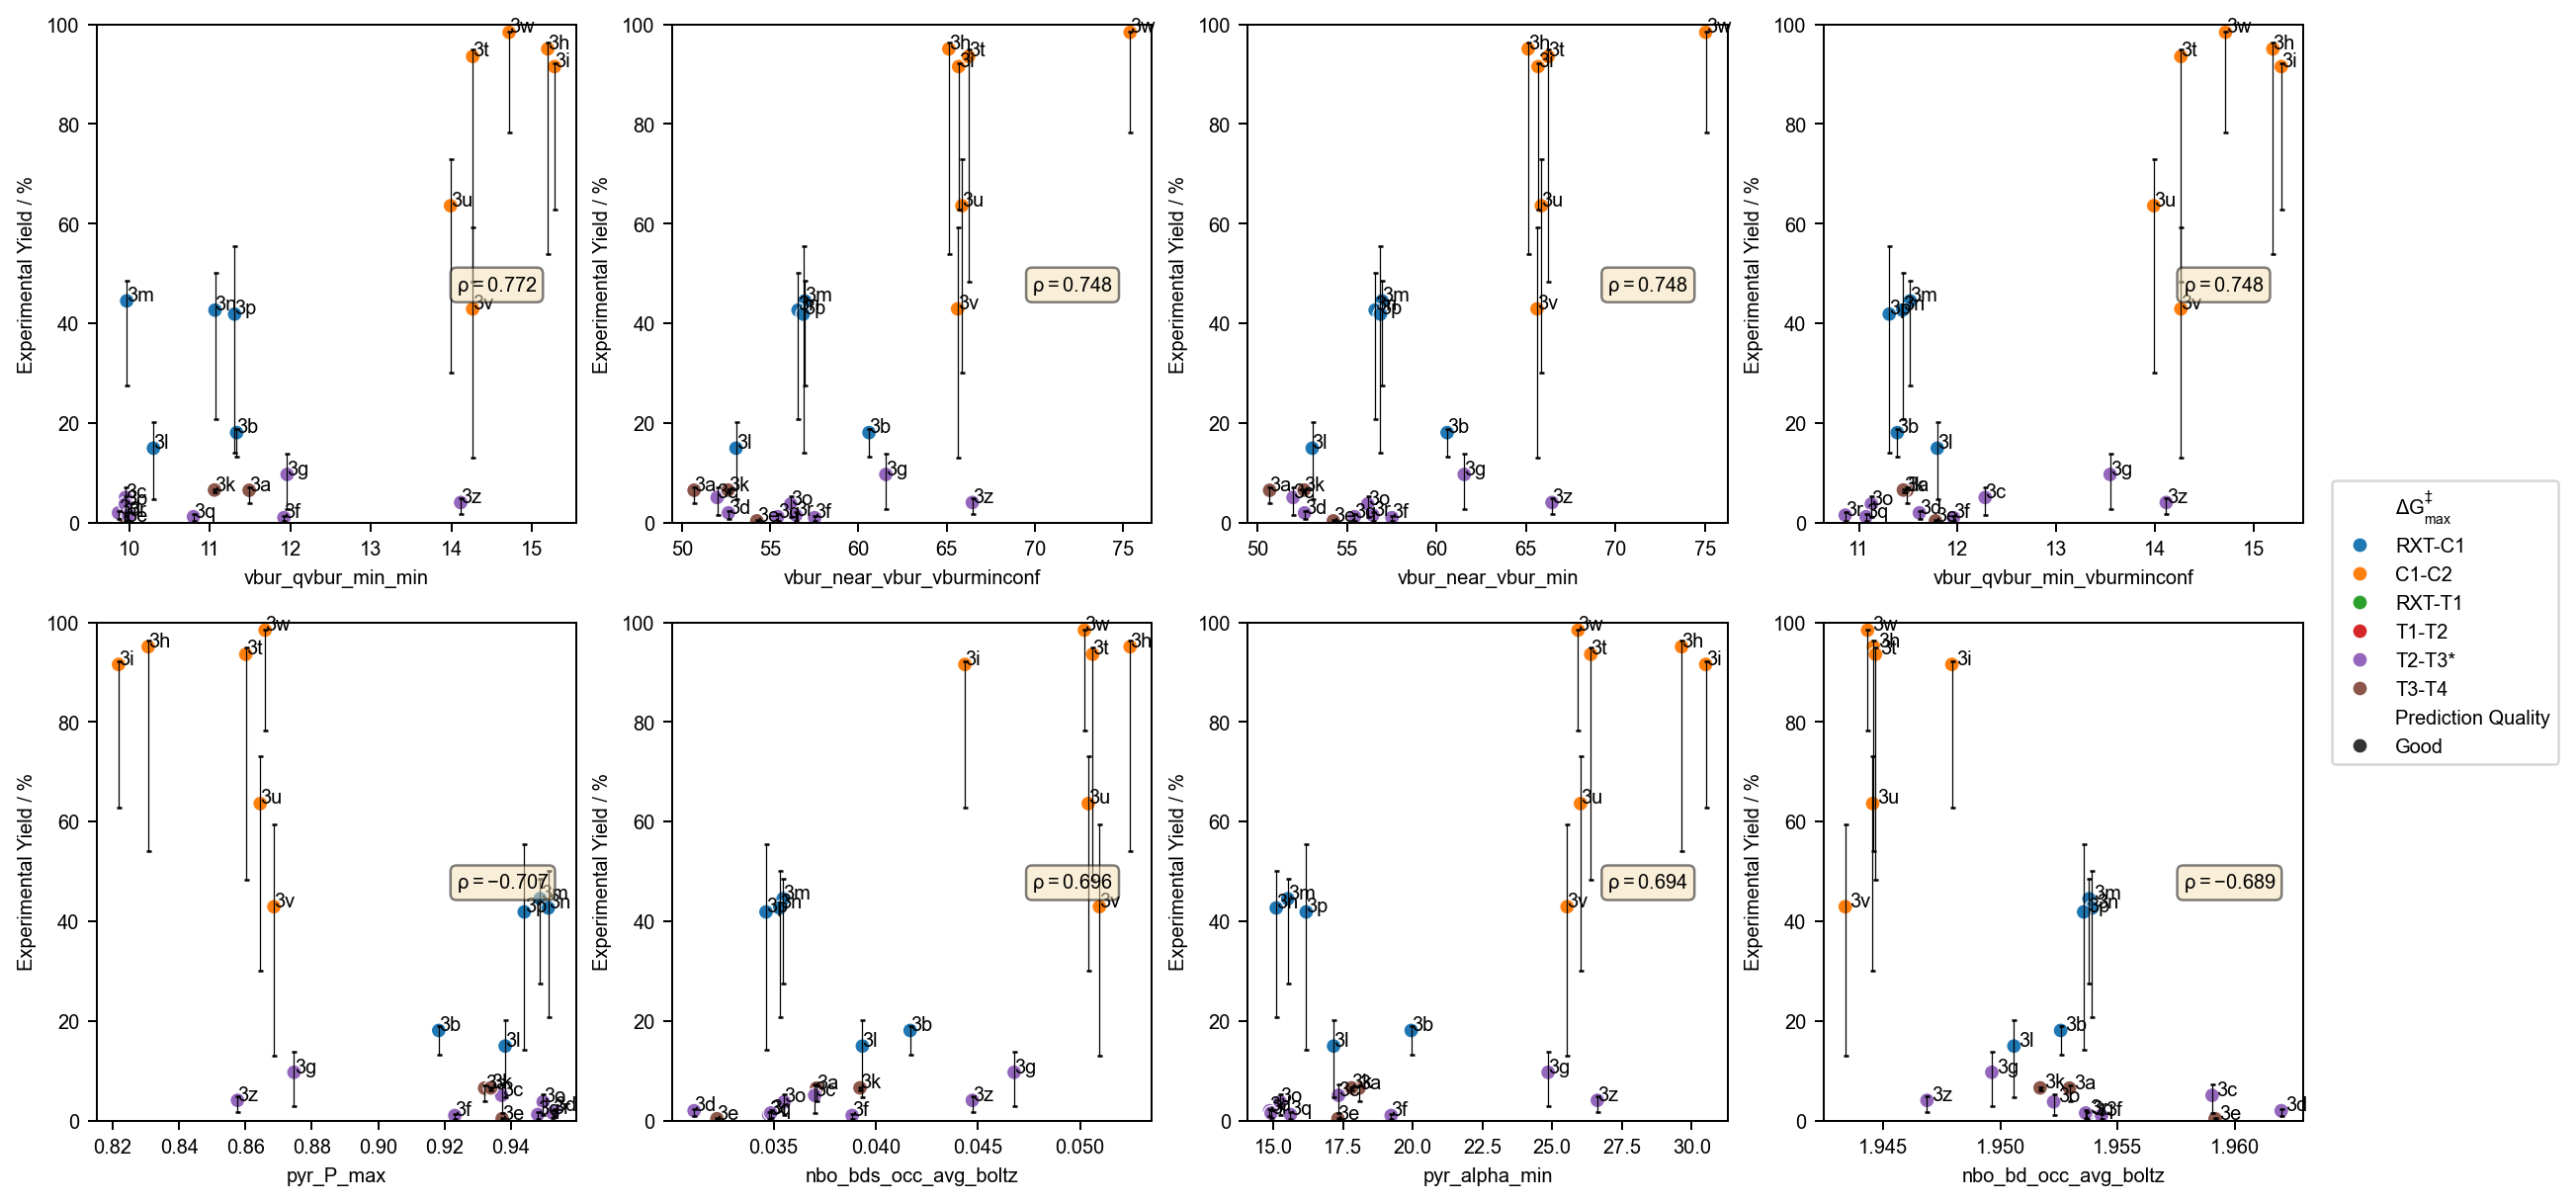

In [57]:
interest = 'comp_good'
#corr_hg[corr_hg[interest] >= 0.4].sort_values(by=interest,ascending=False)
corr_df_tmp = corr_df.sort_values(by='comp_good_abs_rank',ascending=True).head(8)

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows,ncols, figsize=(16,8), dpi=180)
equiv = 3.5
hue_order = ['02-ts-rxt-c1', '04-ts-c1-c2', '12-ts-rxt-t1', '14-ts-t1-t2', f'17-ts-t2-t3-corr_{equiv}', '20-ts-t3-t4']

for n, col in enumerate(corr_df_tmp['descriptor']):
    i = n // ncols
    j = n % ncols
    x = col
    y = f'nice_comp_yield_{equiv}_main'
    g = sns.scatterplot(x=x, y=y, data=kraken_good, hue_order=hue_order, palette='tab10', style=kraken_good['prediction_quality'], hue=f'max_overall_corr_{equiv}_name', ax=ax[i][j])
    g5 = ax[i][j].errorbar(x=x, y=y, yerr=(kraken_good[f'nice_comp_yield_{equiv}_main_minus'], kraken_good[f'nice_comp_yield_{equiv}_main_plus']), data=kraken_good, fmt='none', ecolor='black', capsize=1, linewidth=0.5, label='_nolegend_')
    for _, row in kraken_good.iterrows():
        ax[i][j].text(row[x]*1.0001, row[y]*1.001, row['exp_name'], fontsize=8)
    ax[i][j].legend_.remove()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[i][j].text(0.75, 0.5, r'$\rho=%.3f$' % (corr_df[corr_df['descriptor'] == col][interest]),
           transform=ax[i][j].transAxes, verticalalignment='top', bbox=props)
    ax[i][j].set_ylabel("Experimental Yield / %")
    ax[i][j].set_ylim(0,100)


text_list = plt.legend(bbox_to_anchor=(1.04,1), loc="center left").get_texts()
text_list[0].set_text("$\Delta$G$^{\u2021}_{max}$")
text_list[1].set_text('RXT-C1')
text_list[2].set_text('C1-C2')
text_list[3].set_text('RXT-T1')
text_list[4].set_text('T1-T2')
text_list[5].set_text('T2-T3*')
text_list[6].set_text('T3-T4')
text_list[7].set_text('Prediction Quality')

#ax.set_xlabel("V$_{bur}$ (min) / %")


plt.savefig("figures/figures103.png", transparent=True, bbox_inches='tight')